<a href="https://colab.research.google.com/github/savinats/LCPb-Project/blob/main/Next_Token_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Model
import transformers
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import re

In [ ]:
#Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
#Encode text
input_text = "My mom is eating unsalted sunflower seeds. She has high blood pressure and cholesterol. "
input_ids = tokenizer.encode(input_text, return_tensors="pt")
tokenized_input = tokenizer.encode(input_text, add_special_tokens=False)

In [ ]:
#Generate text
output_ids = input_ids #initialize
num_tokens = len(tokenized_input)
print(f"Number of tokens in the input sentence: {num_tokens}")
print([tokenizer.decode(i)+" " for i in tokenized_input])

Number of tokens in the input sentence: 19
['My ', ' mom ', ' is ', ' eating ', ' uns ', 'alted ', ' sun ', 'flower ', ' seeds ', '. ', ' She ', ' has ', ' high ', ' blood ', ' pressure ', ' and ', ' cholesterol ', '. ', '  ']


**Generated text**

In [ ]:
#Decode and print the final generated text
#setting the parameters
max_length = 75
do_sample = True            # enable sampling to be able to change the following parameters
top_k = 50                  # considers only the top k most probable next tokens
top_p = 0.95                # it dynamically chooses the number of tokens to consider, based on their cumulative probability.
temperature = 0.7           # controls the randomness of predictions; applies temp before softmax. T<1: model more deterministic, T>1: output's more random + diverse
repetition_penalty = 1.1    # encourages more diverse output

attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

#output = model.generate(input_ids, max_length = 100)
output = model.generate(
    input_ids,
    attention_mask = attention_mask,
    max_length=75,
    pad_token_id=tokenizer.eos_token_id, # the eos token_id default is 50256 (like the warning said)
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.8,
    repetition_penalty=1.1
)
text_output = tokenizer.decode(output[0], skip_special_tokens=True)

print(f"\n*Input text: {input_text}")
print(f"*Generated text: {text_output}")

#not complete answer????


*Input text: My mom is eating unsalted sunflower seeds. She has high blood pressure and cholesterol. 
*Generated text: My mom is eating unsalted sunflower seeds. She has high blood pressure and cholesterol.  She gets out of bed one day at 7am, wakes up early the next morning to find her room full but she's not sleeping because there are no lights on in my house or they're dark so I'm still asleep when we wake him," he told The Times.


**Token by token selection:**

The vocabulary dimension contains the logits for each token (voc size of gpt2 is 50257)

Logits are the output of the final layer before softmax and they represent unormalized scores or probabilities

In [ ]:
# Logits
for _ in range(max_length - len(input_ids[0])):
  outputs = model(output_ids, output_attentions=True)

  logits = outputs.logits[:,-1,:] #batch_size, sequence_length, vocab_size
  probs = torch.softmax(logits, dim=-1) #softmax func to convert logits tensor to probabilities
  next_token_id = torch.argmax(probs, dim=-1).unsqueeze(-1) #selects token with highest prob from probs for each sequence

  print(f"**Logits for next possible token: {logits}")
  print(f"**Probabilities for next possible token: {probs}")
  print(f"**Next token ID: {next_token_id}")
  print(f"**Next token: {tokenizer.decode(next_token_id[0])}")

  #Append the next token to the input_ids
  output_ids = torch.cat([output_ids, next_token_id], dim=-1)

#Print attention weights
#for i, attn in enumerate(outputs.attentions):
#  print(f"Layer {i + 1} attention shape: {attn.shape}")
#  print(attn)
  # attn has shape [batch_size, num_heads, sequence_length, sequence_length]

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


**Logits for next possible token: tensor([[-61.7778, -63.3277, -64.3894,  ..., -71.3819, -69.9168, -64.6930]],
       grad_fn=<SliceBackward0>)
**Probabilities for next possible token: tensor([[1.0883e-05, 2.3102e-06, 7.9906e-07,  ..., 7.3412e-10, 3.1772e-09,
         5.8982e-07]], grad_fn=<SoftmaxBackward0>)
**Next token ID: tensor([[3711]])
**Next token: iced
**Logits for next possible token: tensor([[-101.4484, -103.3080, -110.3323,  ..., -112.3722, -108.0769,
         -104.6223]], grad_fn=<SliceBackward0>)
**Probabilities for next possible token: tensor([[1.0720e-04, 1.6695e-05, 1.4857e-08,  ..., 1.9321e-09, 1.4174e-07,
         4.4850e-06]], grad_fn=<SoftmaxBackward0>)
**Next token ID: tensor([[8887]])
**Next token:  tea
**Logits for next possible token: tensor([[-81.6065, -85.7650, -91.1106,  ..., -94.5603, -95.4727, -86.0810]],
       grad_fn=<SliceBackward0>)
**Probabilities for next possible token: tensor([[1.2766e-02, 1.9953e-04, 9.5162e-07,  ..., 3.0217e-08, 1.2135e-08,
    

**PLOTS FOR NEXT MOST PROBABLE TOKEN *WITHOUT*  USING THE MULTINOMIAL DISTRIBUTION & SAMPLING + TOTAL ENTROPY**

Generated so far: Pancakes are great for a


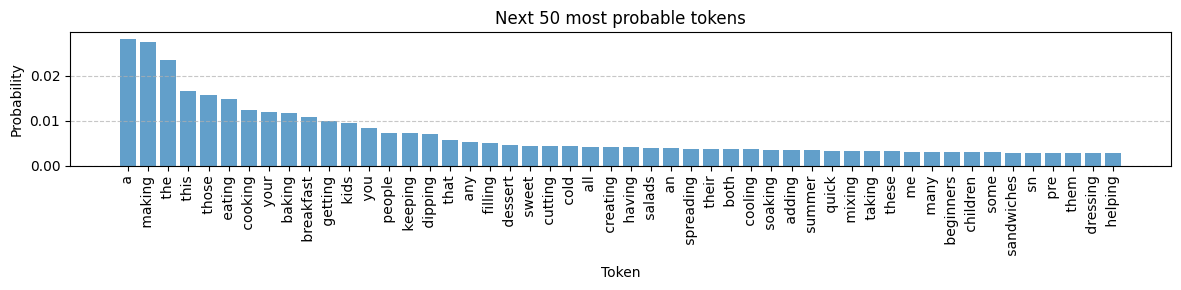

Generated so far: Pancakes are great for a quick


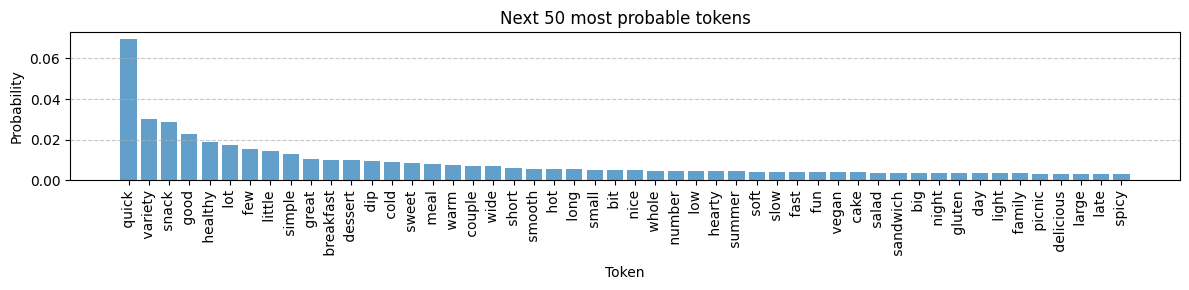

Generated so far: Pancakes are great for a quick snack


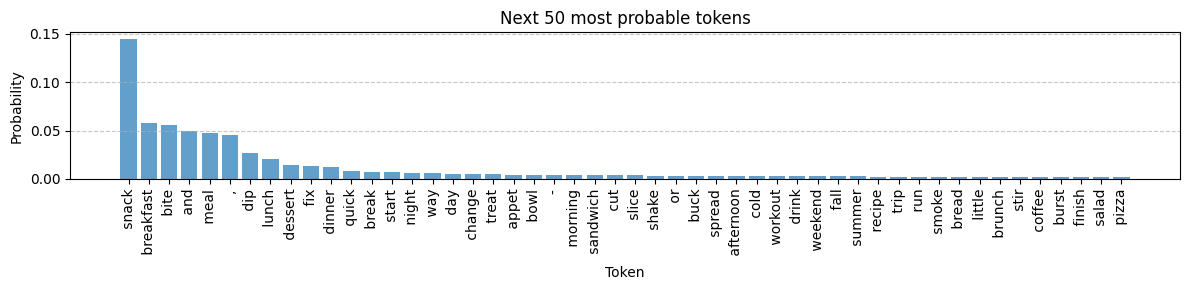

Generated so far: Pancakes are great for a quick snack,


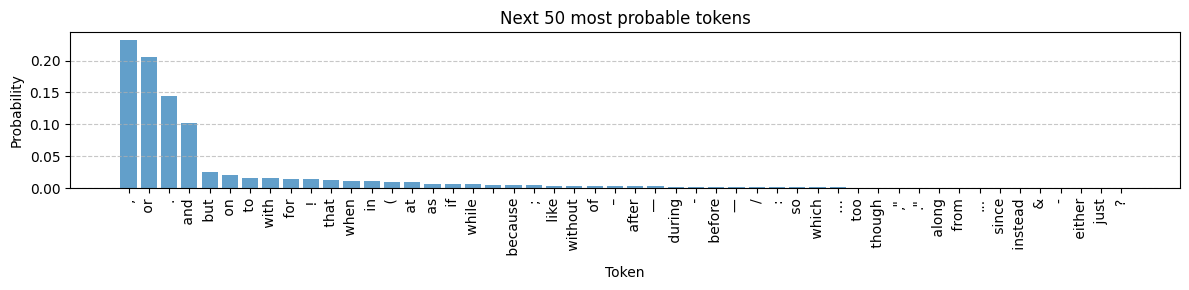

Generated so far: Pancakes are great for a quick snack, but


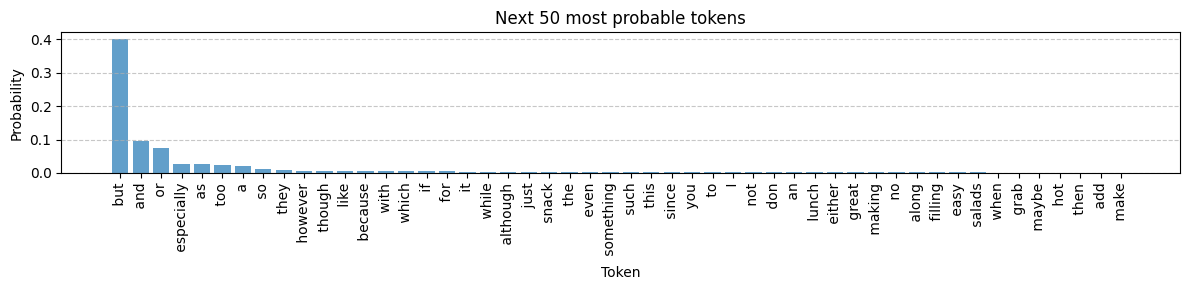

Generated so far: Pancakes are great for a quick snack, but they


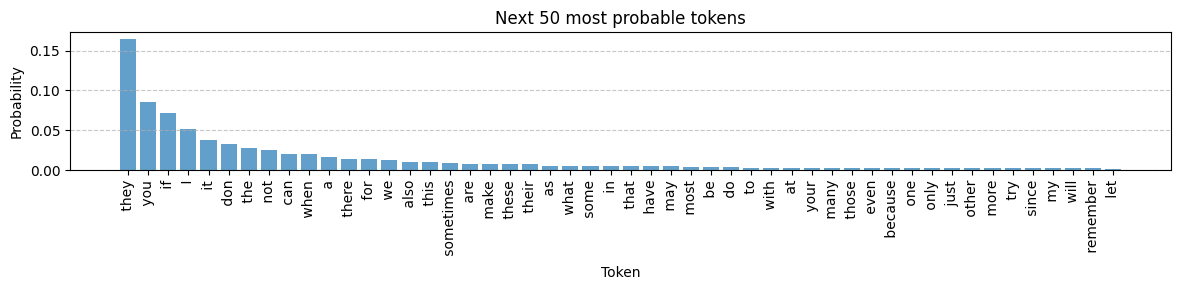

Generated so far: Pancakes are great for a quick snack, but they're


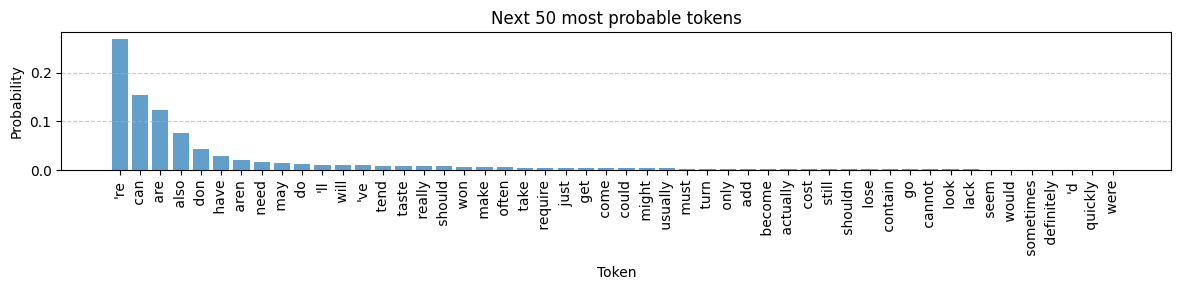

Generated so far: Pancakes are great for a quick snack, but they're also


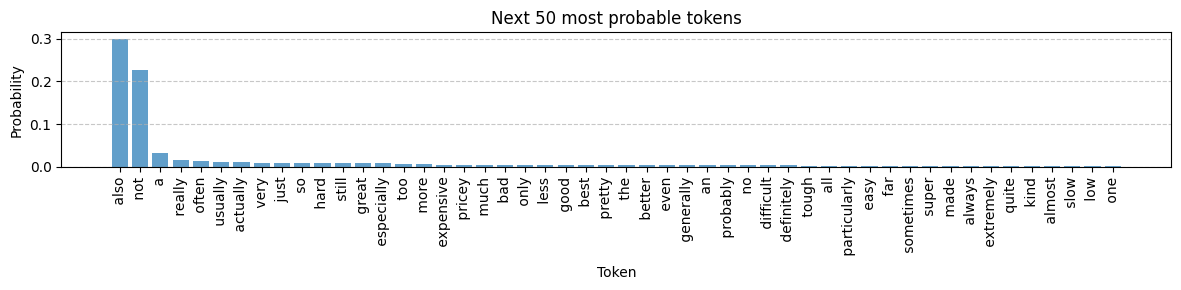

Generated so far: Pancakes are great for a quick snack, but they're also great


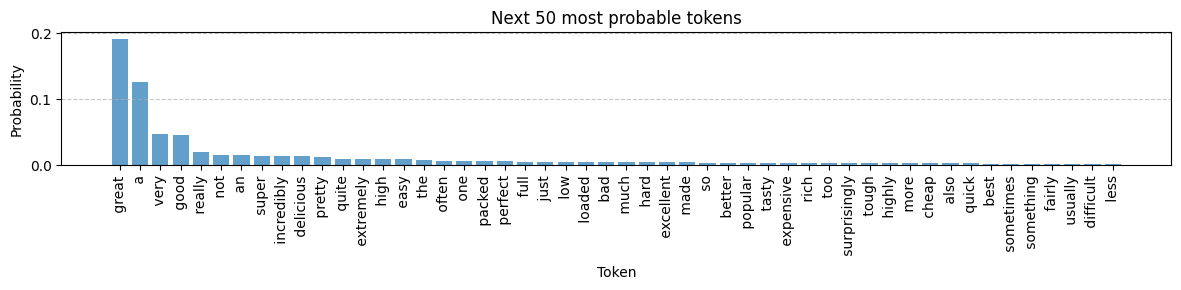

Generated so far: Pancakes are great for a quick snack, but they're also great for


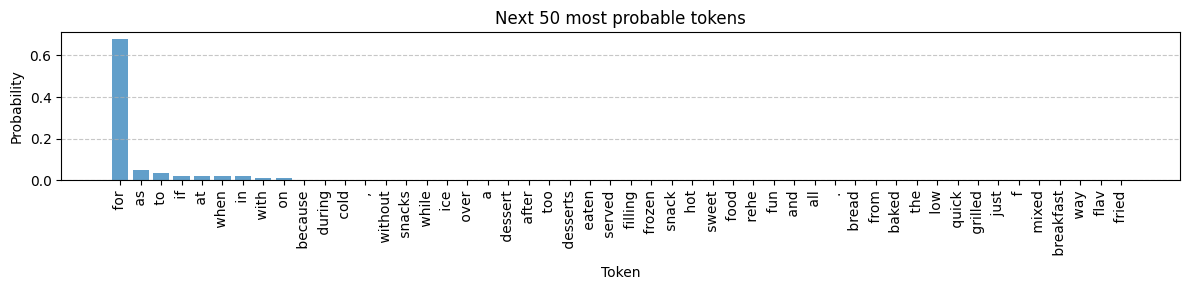

Generated so far: Pancakes are great for a quick snack, but they're also great for a


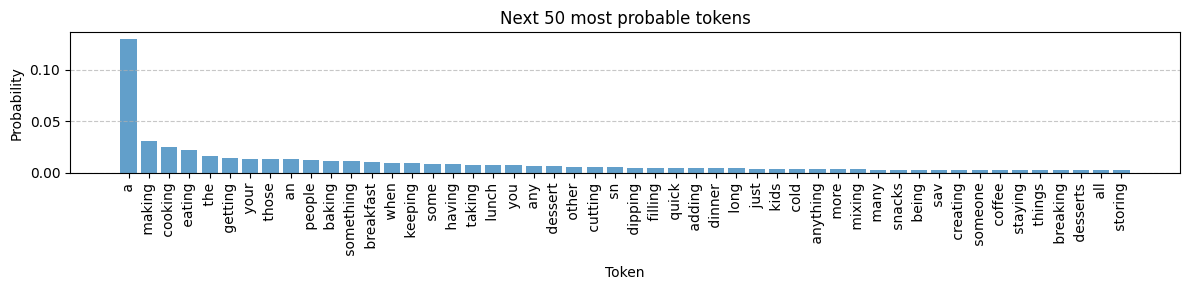

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick


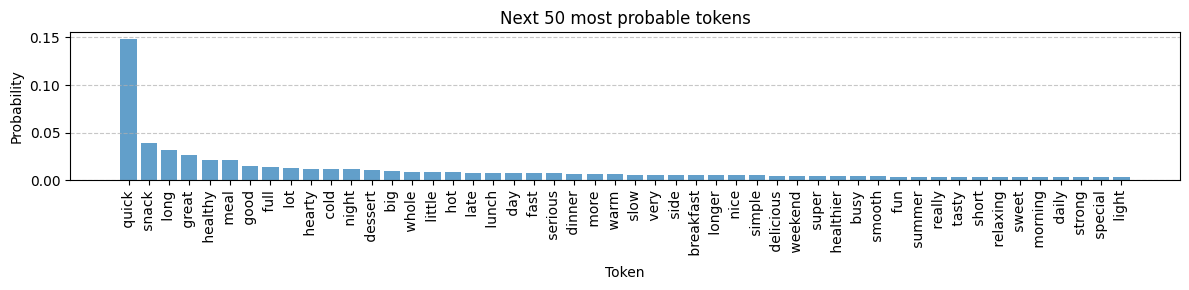

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal


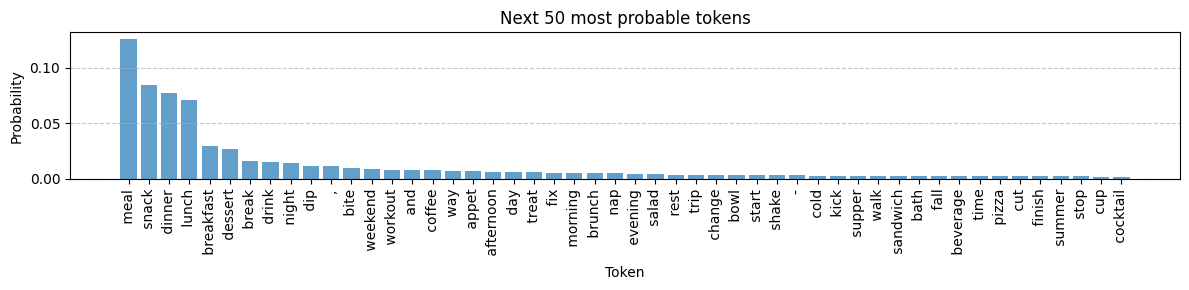

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.


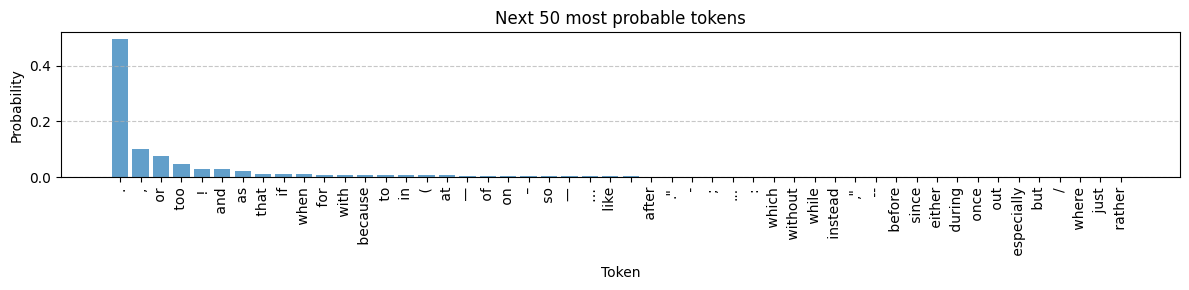

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.



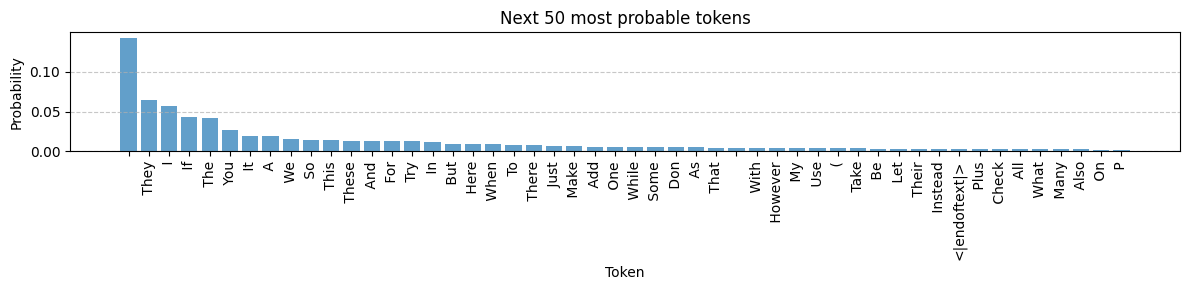

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.




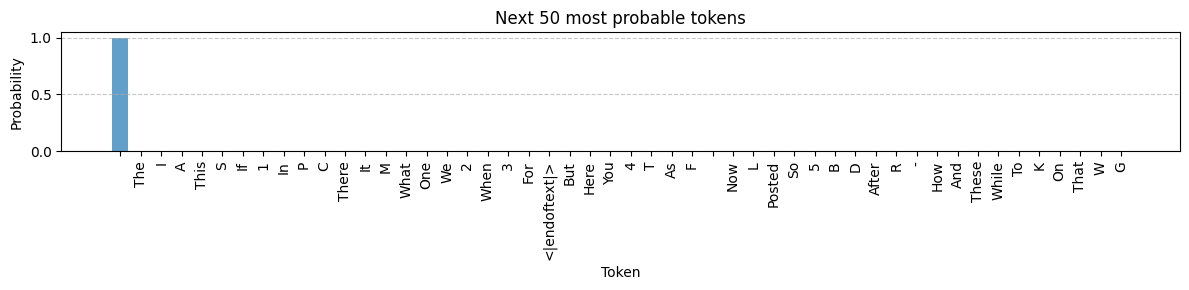

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The


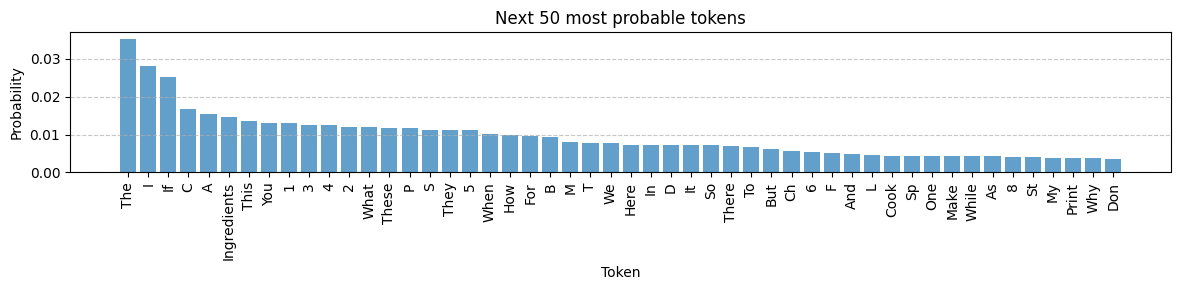

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best


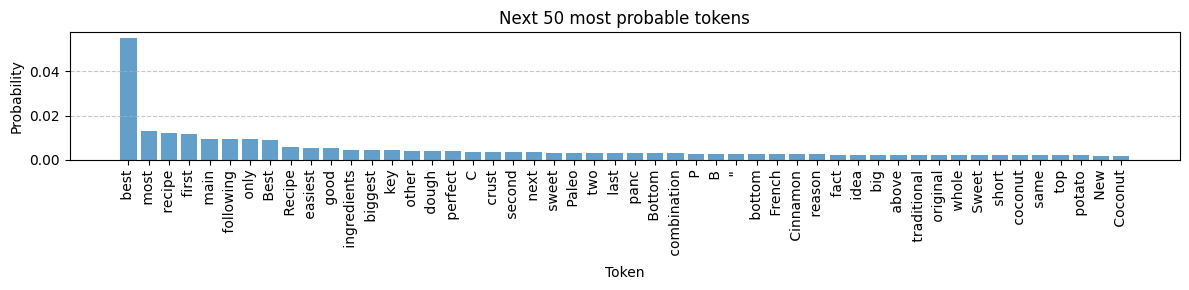

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part


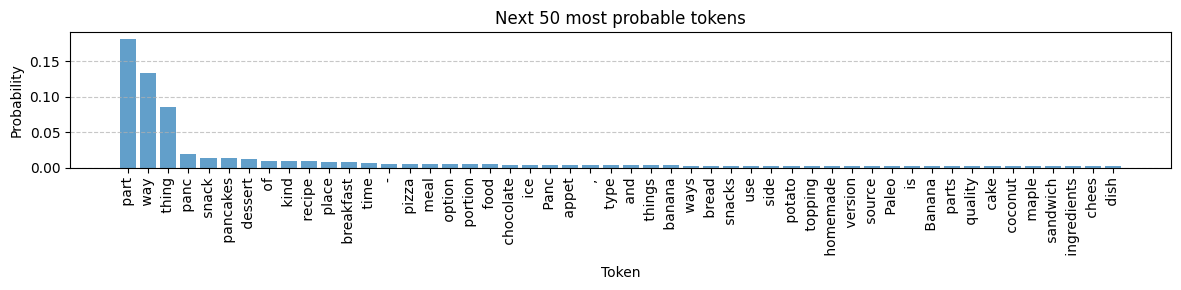

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about


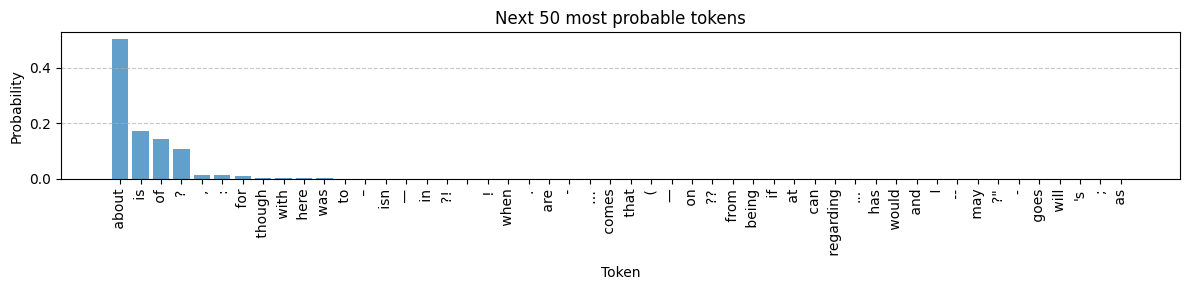

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these


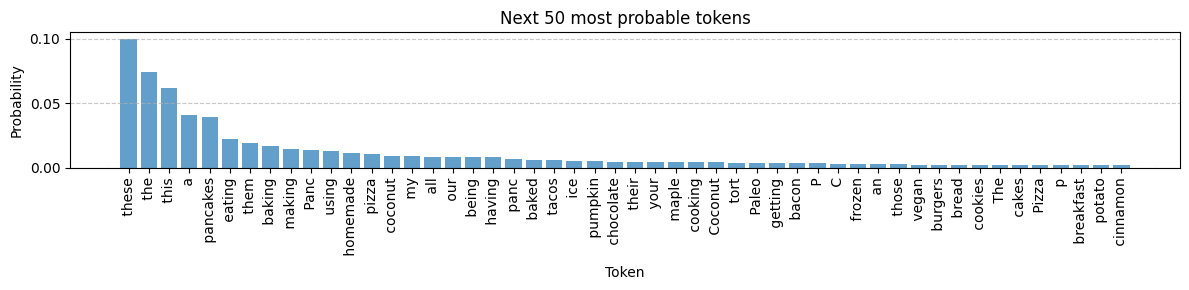

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes


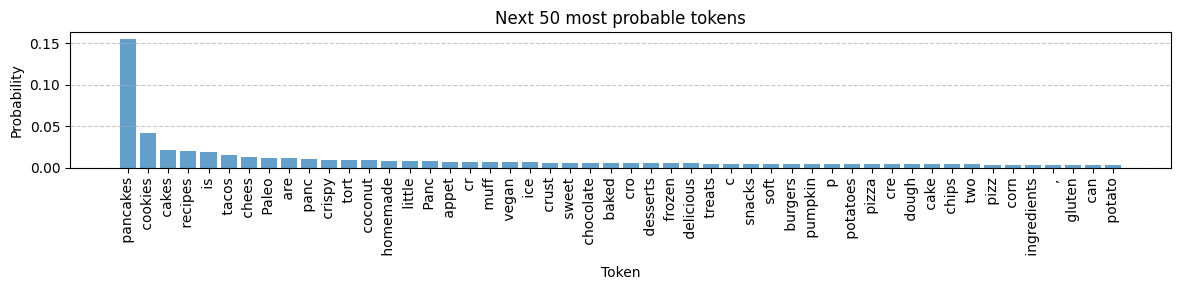

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is


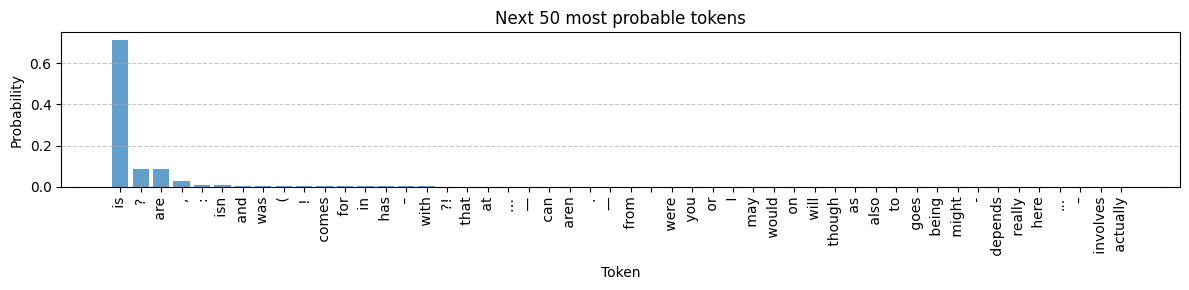

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that


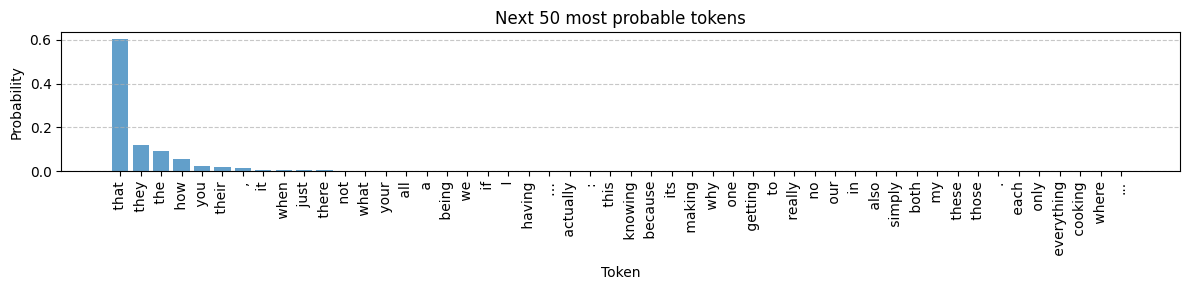

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they


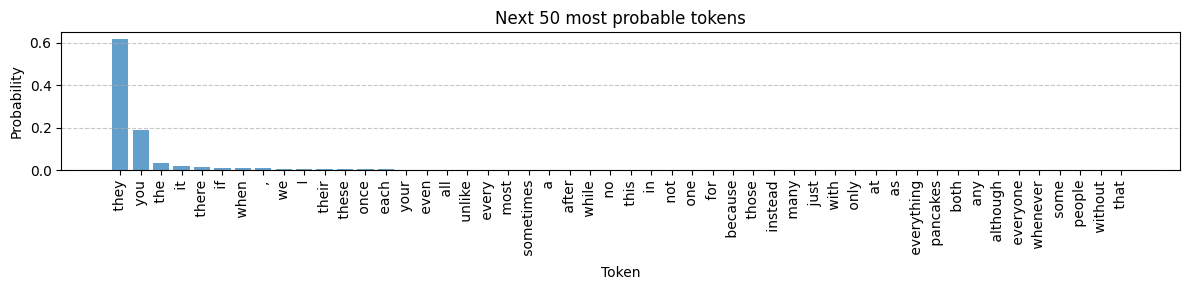

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're


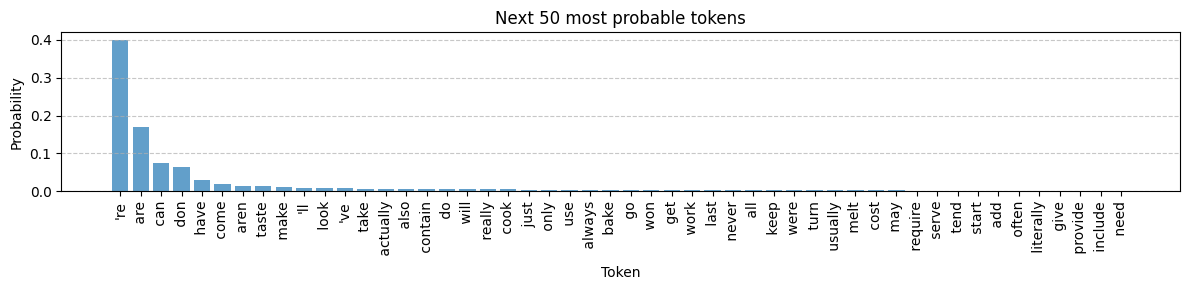

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made


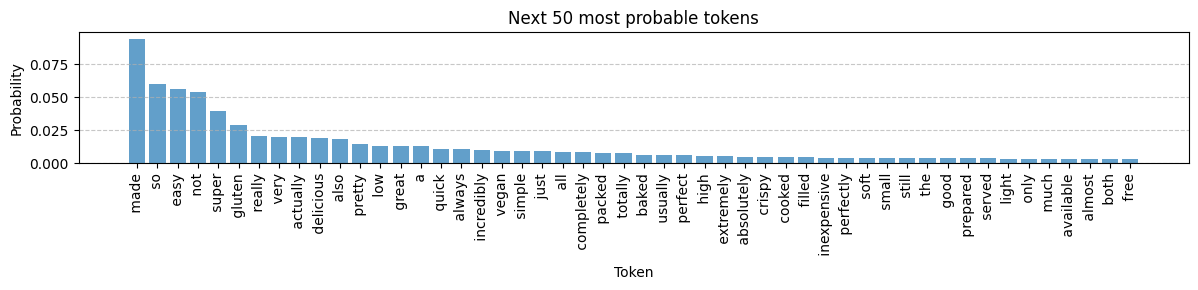

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with


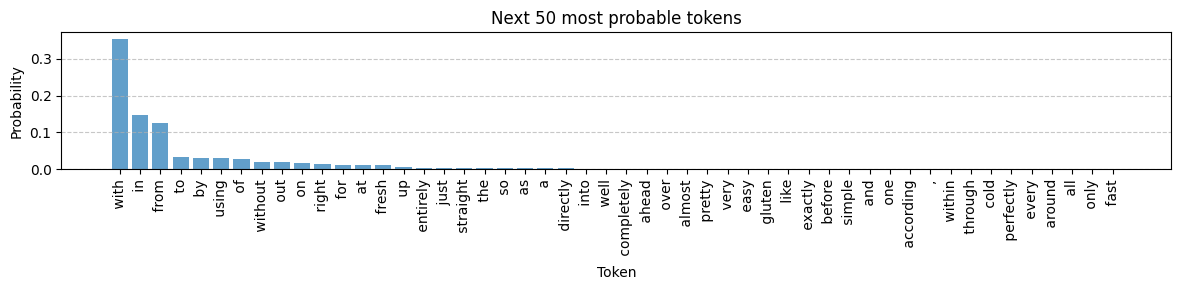

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a


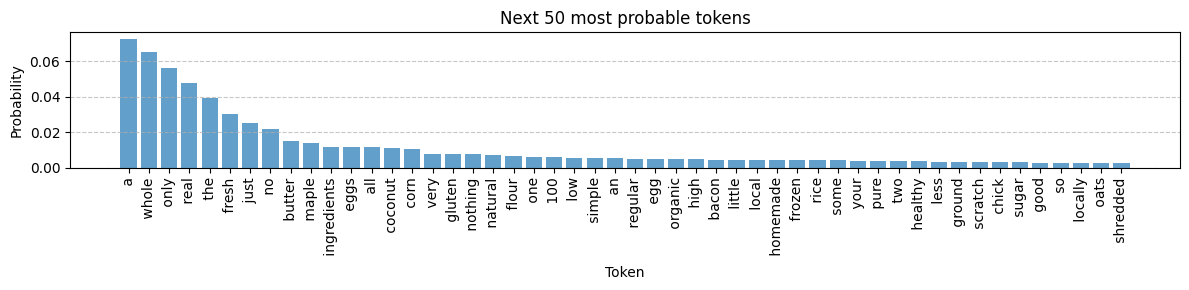

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole


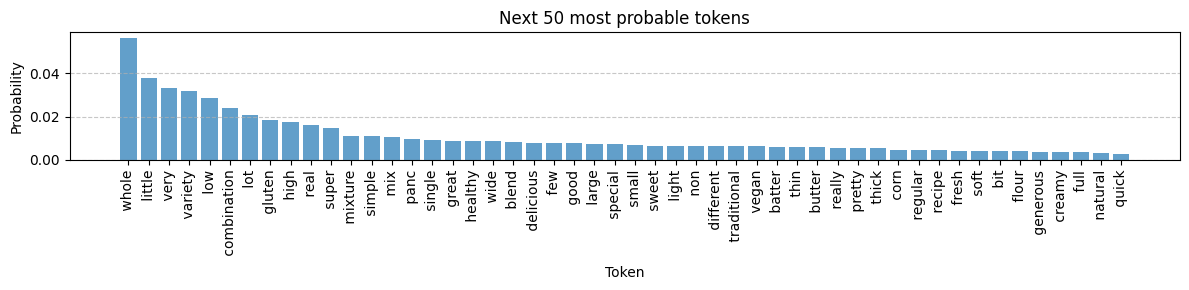

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat


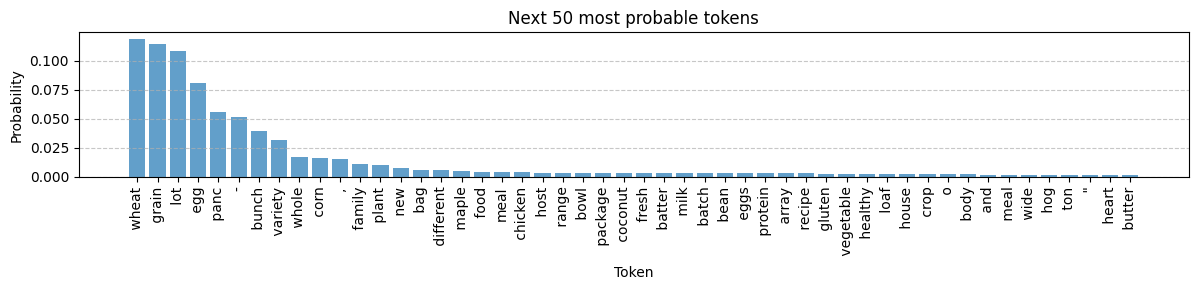

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour


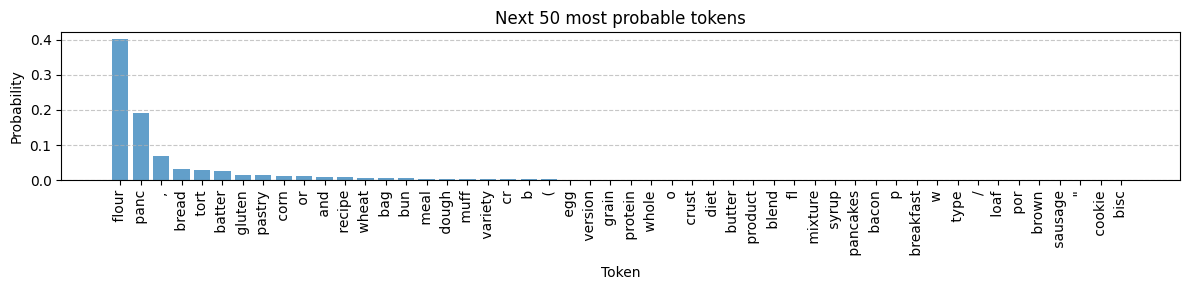

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour.


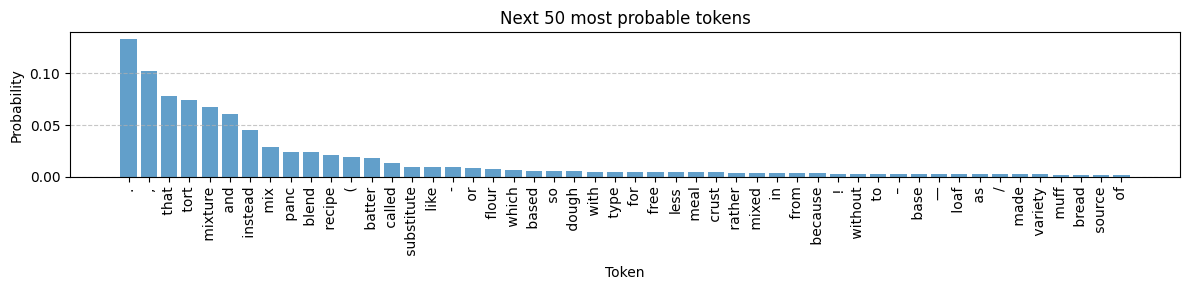

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This


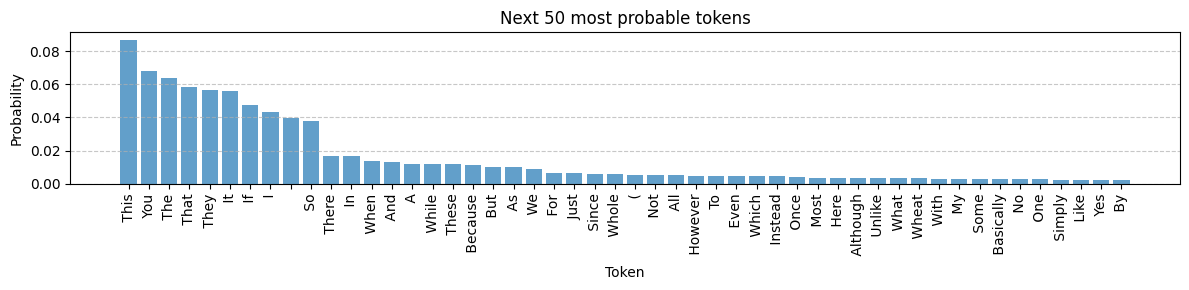

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This means


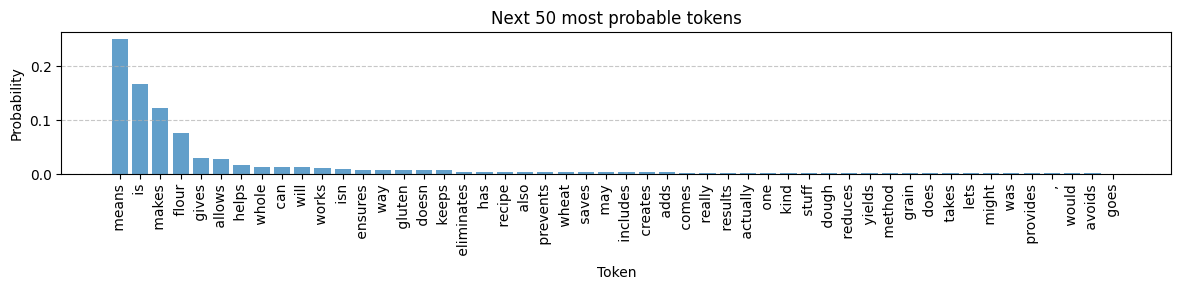

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This means that


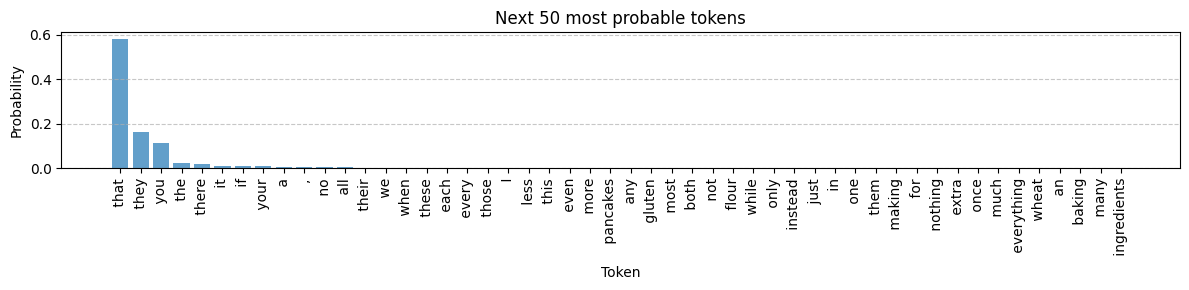

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This means that they


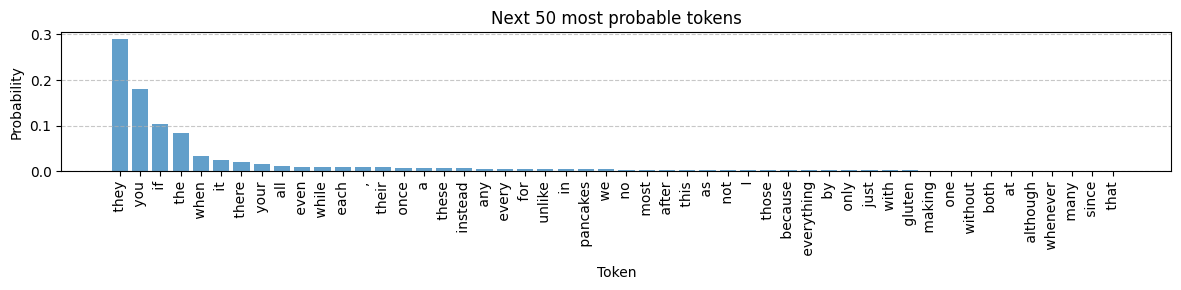

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This means that they're


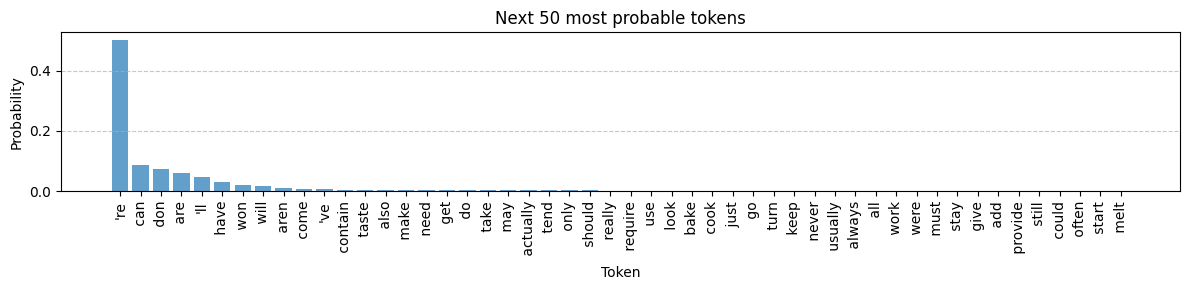

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This means that they're gluten


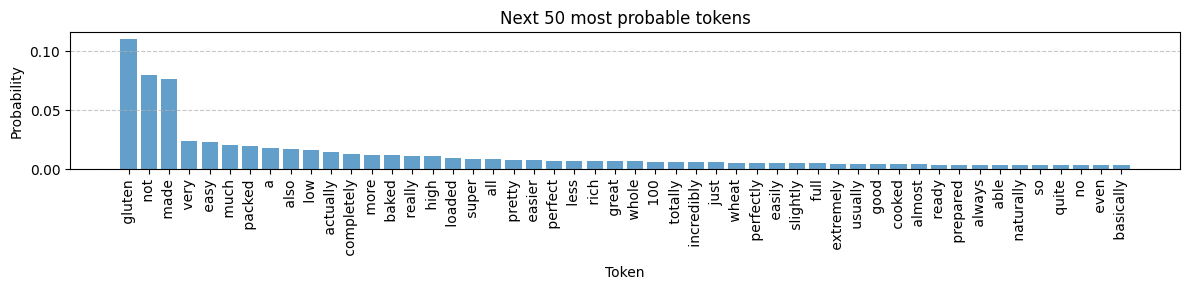

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This means that they're gluten-


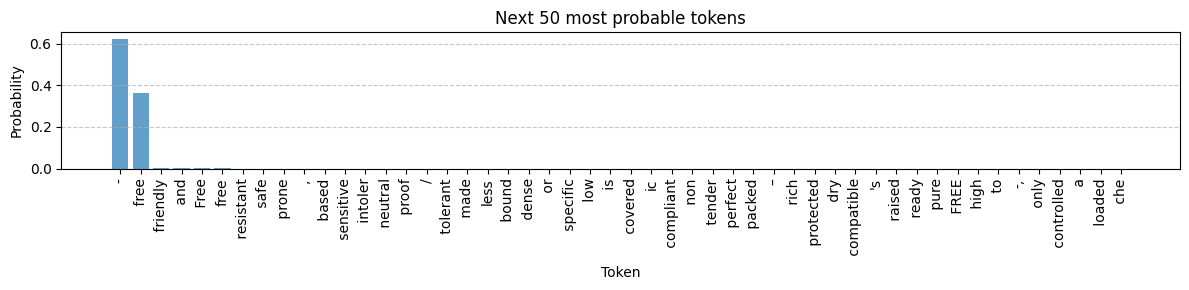

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This means that they're gluten-free


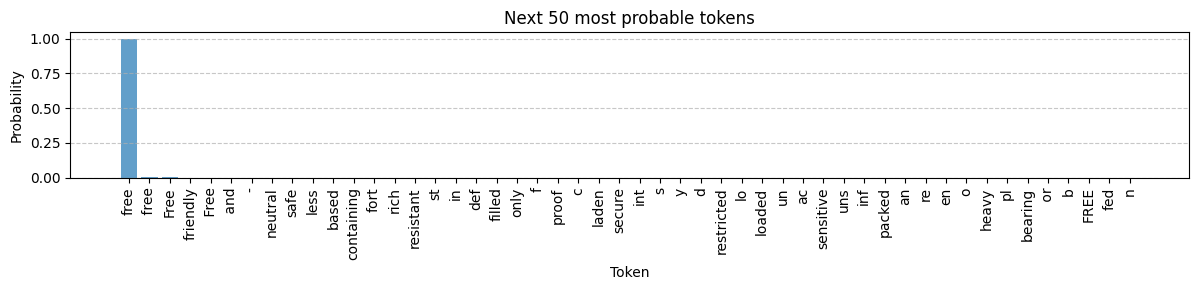

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This means that they're gluten-free,


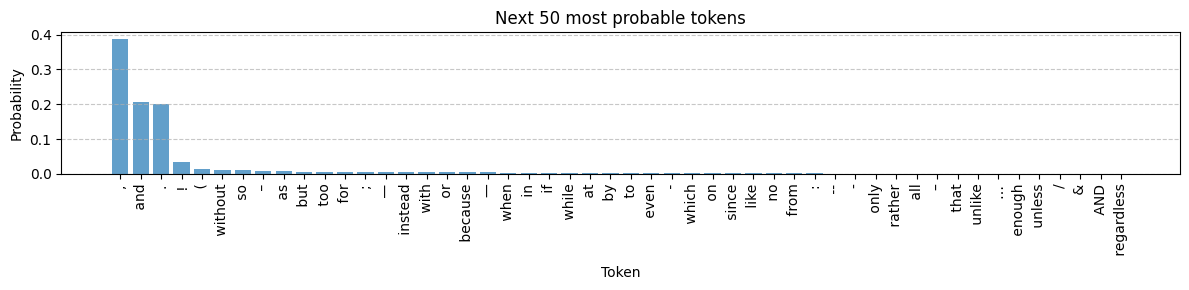

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This means that they're gluten-free, and


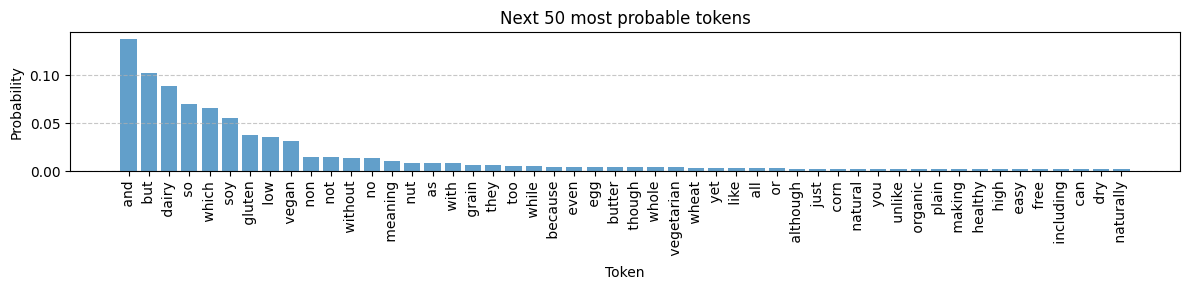

Generated so far: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This means that they're gluten-free, and they


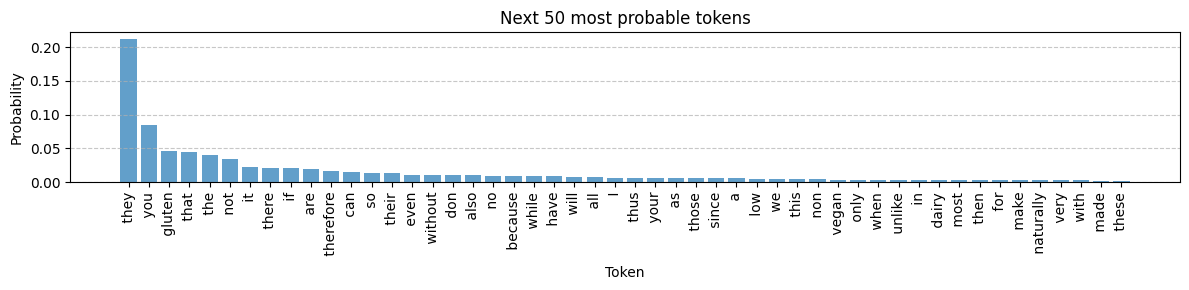

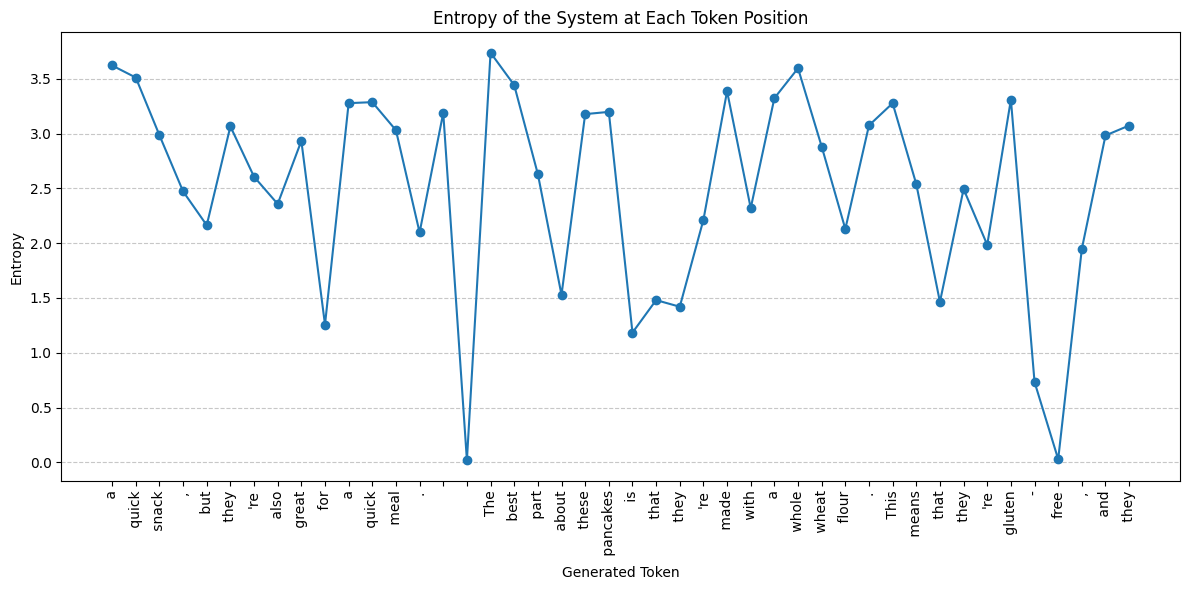

Input text: Pancakes are great for...
**Final generated text: Pancakes are great for a quick snack, but they're also great for a quick meal.

The best part about these pancakes is that they're made with a whole wheat flour. This means that they're gluten-free, and they


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import re

input_text = "Pancakes are great for"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

max_length = 50

# Function to remove non-ASCII characters
def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

# Store the entropy values and corresponding tokens
entropies = []
generated_tokens = []

for _ in range(max_length - len(input_ids[0])):

    # Pass the current input_ids through the model to get the logits
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=torch.ones(input_ids.shape, dtype=torch.long))

    logits = outputs.logits[:, -1, :]  # Get the logits for the last token

    probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities

    # Extract the top 50 probabilities and their indices
    top_probs, top_indices = torch.topk(probs, 50)

    # Convert to numpy for entropy calculation
    top_probs_np = top_probs.detach().numpy().flatten()

    # Calculate entropy for the top 50 probabilities and store it
    entropies.append(entropy(top_probs_np))

    next_token_id = torch.argmax(probs, dim=-1).unsqueeze(-1)  # Select the token with the highest probability

    input_ids = torch.cat([input_ids, next_token_id], dim=-1)  # Append the selected token to the input sequence

    # Decode the current state of the sequence and remove non-ASCII characters
    current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    current_text = remove_non_ascii(current_text)
    print(f"Generated so far: {current_text}")

    # Store the generated token
    generated_token = tokenizer.decode(next_token_id[0], skip_special_tokens=True)
    generated_token = remove_non_ascii(generated_token)
    generated_tokens.append(generated_token)

    # Decode the top indices to get their corresponding tokens
    top_tokens = [tokenizer.decode([idx]) for idx in top_indices.detach().numpy().flatten()]

    # Plotting them
    plt.figure(figsize=(12, 3))
    plt.bar(np.arange(50), top_probs_np, alpha=0.7)
    plt.xlabel('Token')
    plt.ylabel('Probability')
    plt.title('Next 50 most probable tokens')
    plt.xticks(np.arange(50), top_tokens, rotation='vertical')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot the entropy
plt.figure(figsize=(12, 6))
plt.plot(entropies, marker='o')
plt.xlabel('Generated Token')
plt.ylabel('Entropy')
plt.title('Entropy of the System at Each Token Position')
plt.xticks(np.arange(len(generated_tokens)), generated_tokens, rotation='vertical')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

final_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
final_text = remove_non_ascii(final_text)
print(f"Input text: {input_text}...")
print(f"**Final generated text: {final_text}")


**PROBABILITIES FOR NEXT MOST PROBABLE TOKEN *USING* THE MULTINOMIAL DISTRUBUTION & SAMPLING + TOTAL ENTROPY**

Seeing that the model has a bias towards choosing the same token over and over again, we try to avoid this by twitching the Temperature parameter. In order to do that, we use the multinomial distribution; the model chooses the next generated token based on a distribution of 50 most probable tokens.

<ipython-input-17-4b84438b1096>:73: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


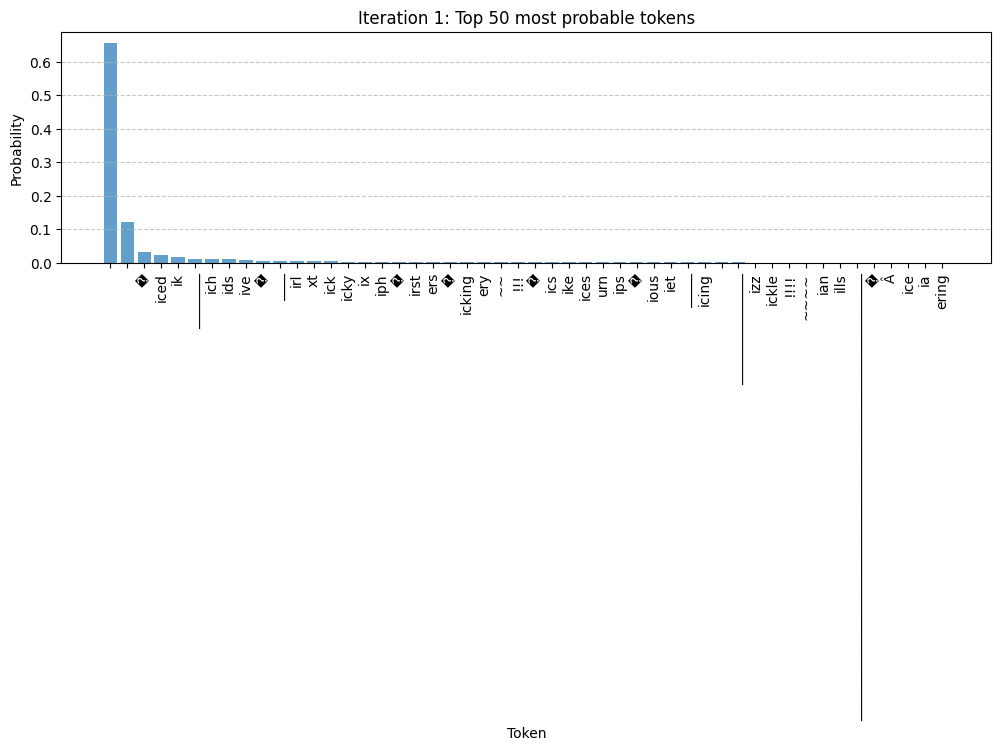

Generated so far: Pancakes are great for   


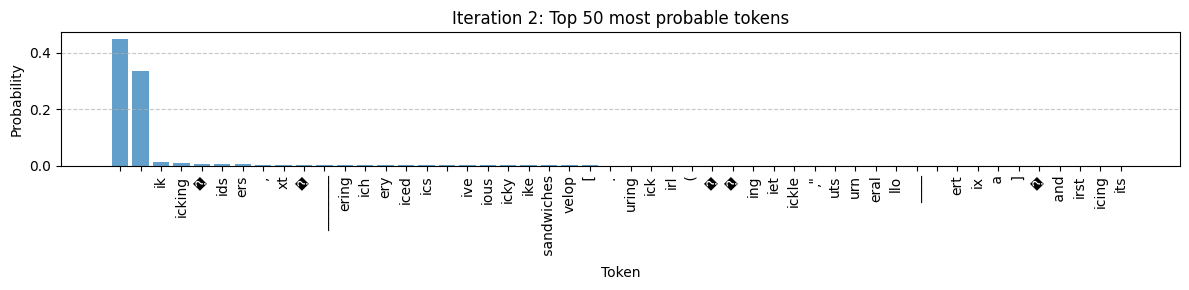

Generated so far: Pancakes are great for   ike


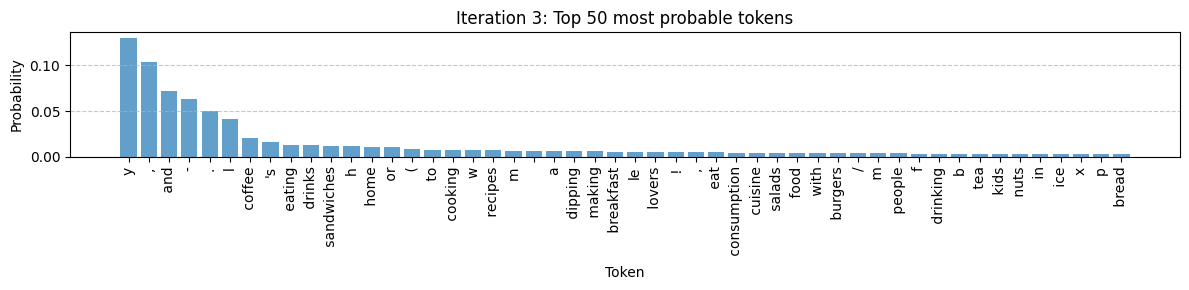

Generated so far: Pancakes are great for   ike plant


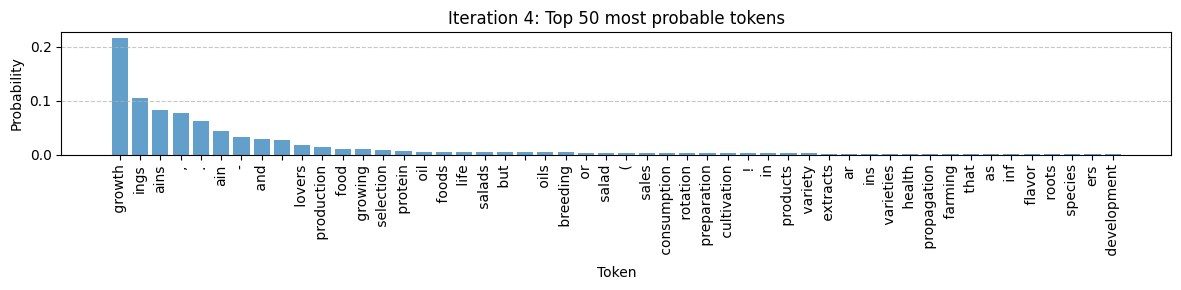

Generated so far: Pancakes are great for   ike plant,


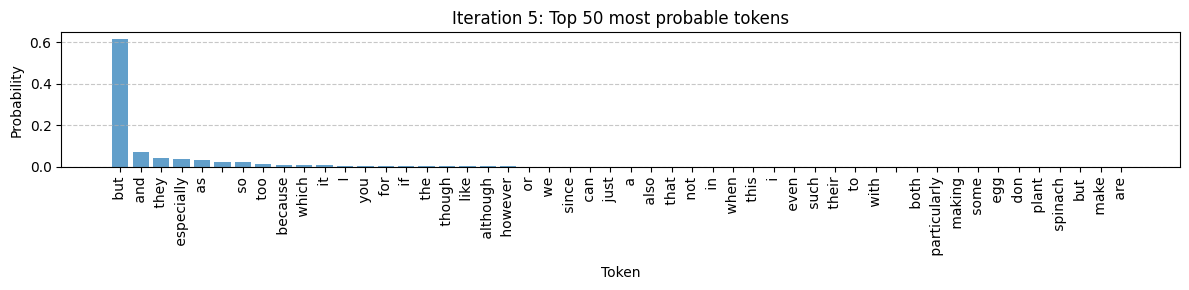

Generated so far: Pancakes are great for   ike plant, they


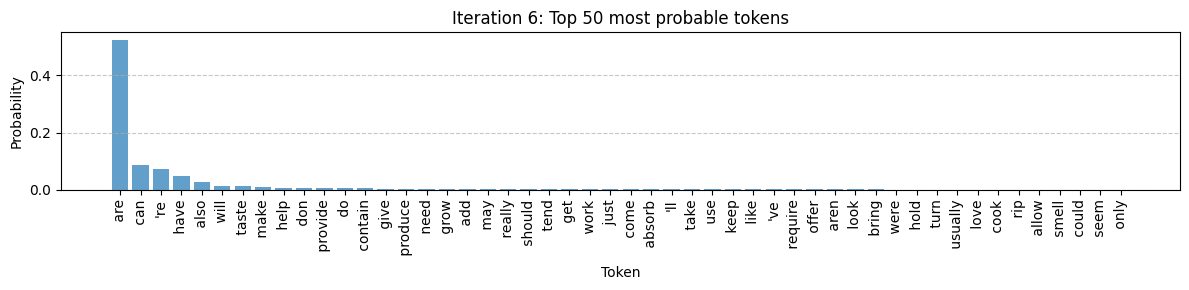

Generated so far: Pancakes are great for   ike plant, they are


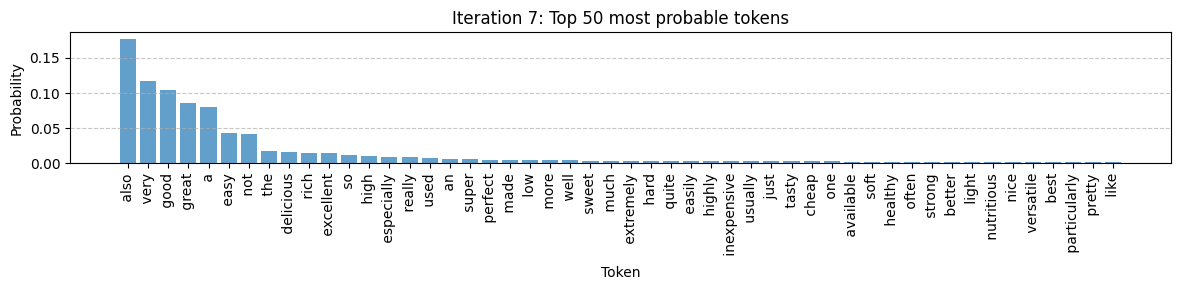

Generated so far: Pancakes are great for   ike plant, they are very


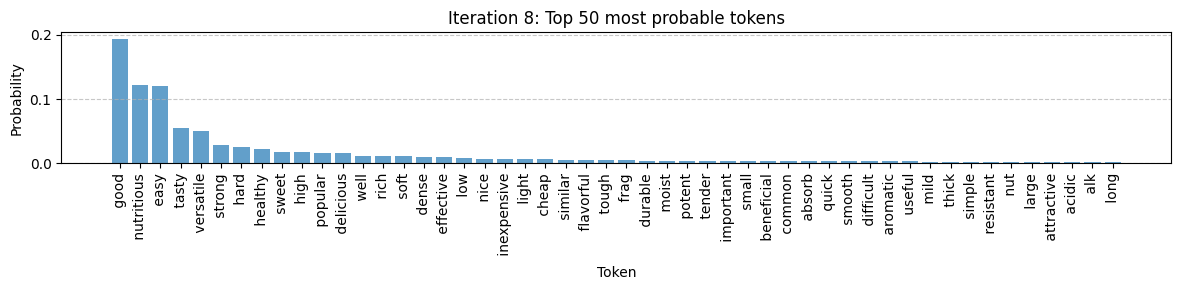

Generated so far: Pancakes are great for   ike plant, they are very moist


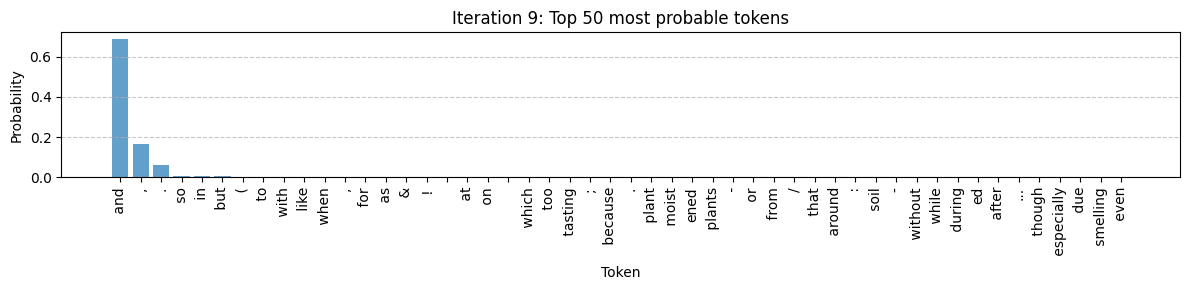

Generated so far: Pancakes are great for   ike plant, they are very moist delicious


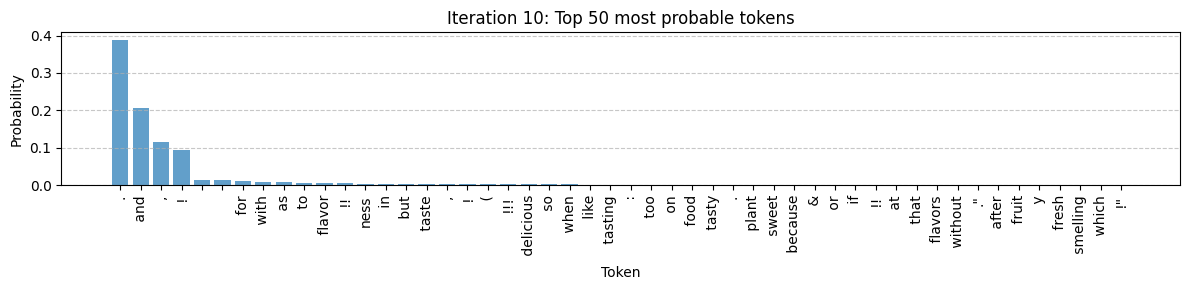

Generated so far: Pancakes are great for   ike plant, they are very moist delicious.


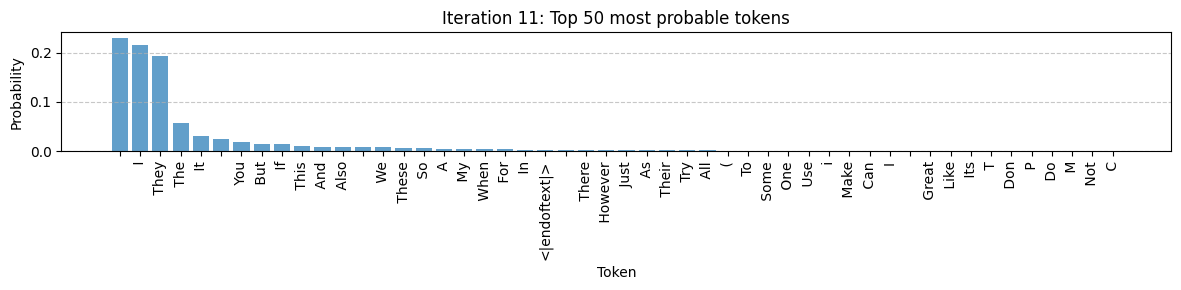

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. M


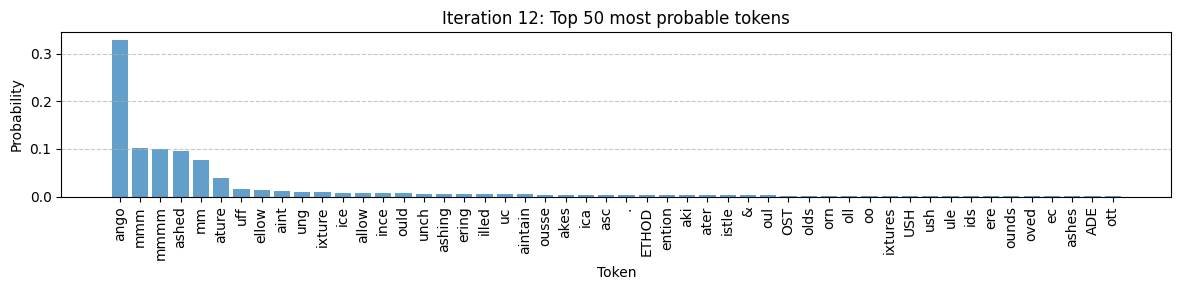

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango


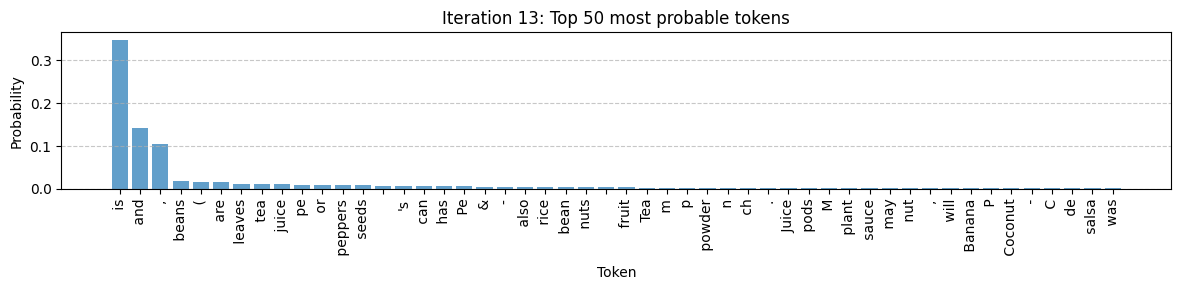

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is


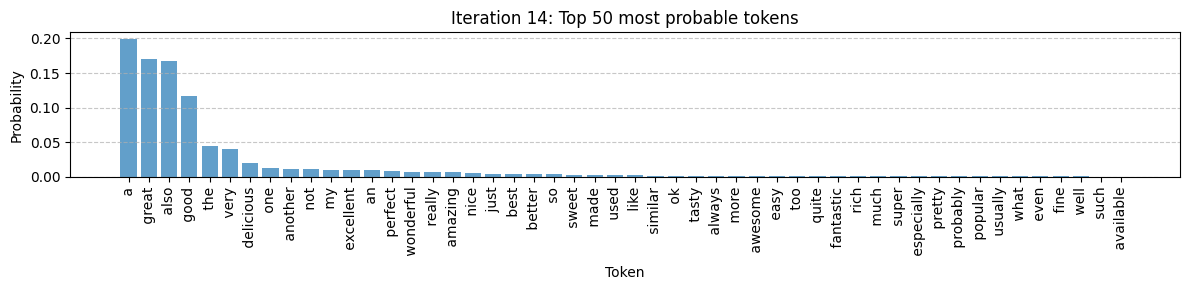

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good


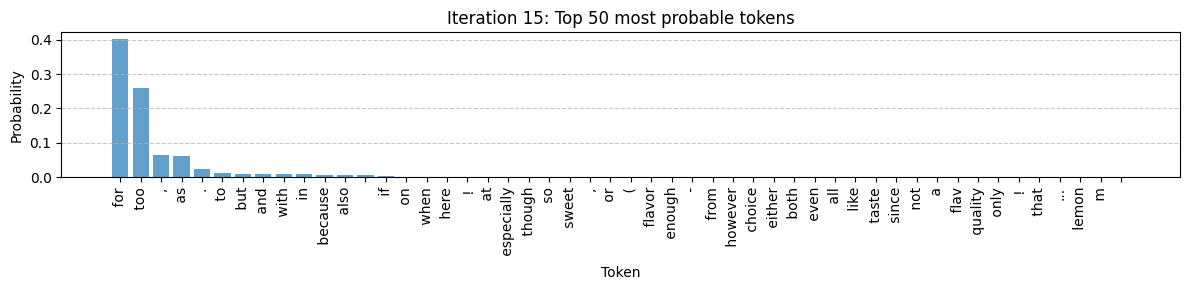

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for


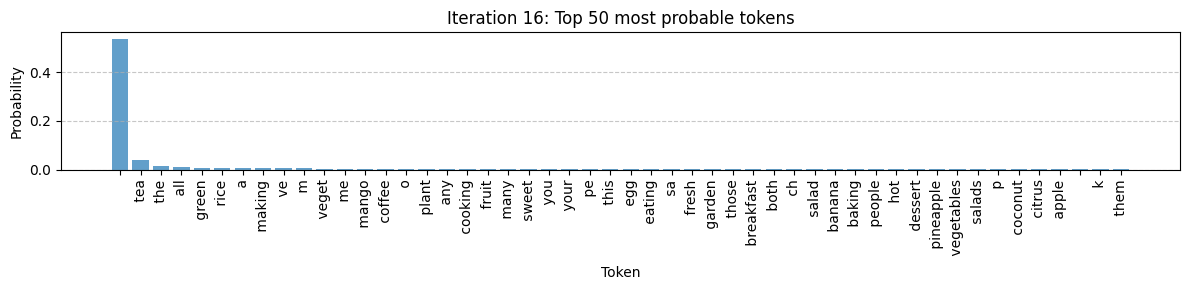

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for 


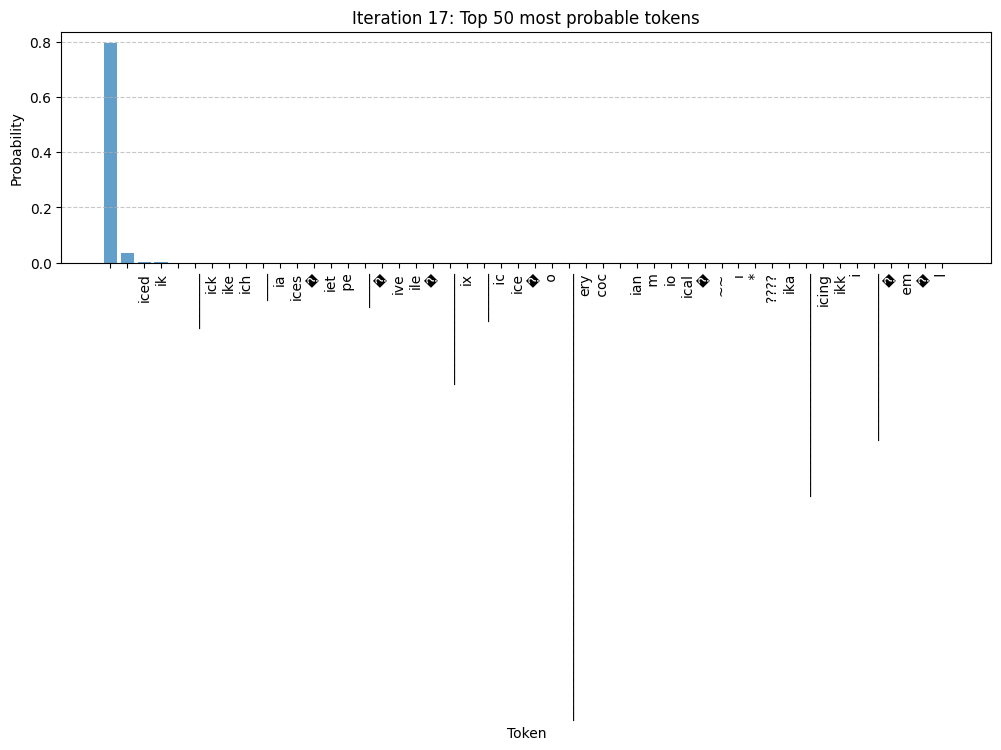

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  


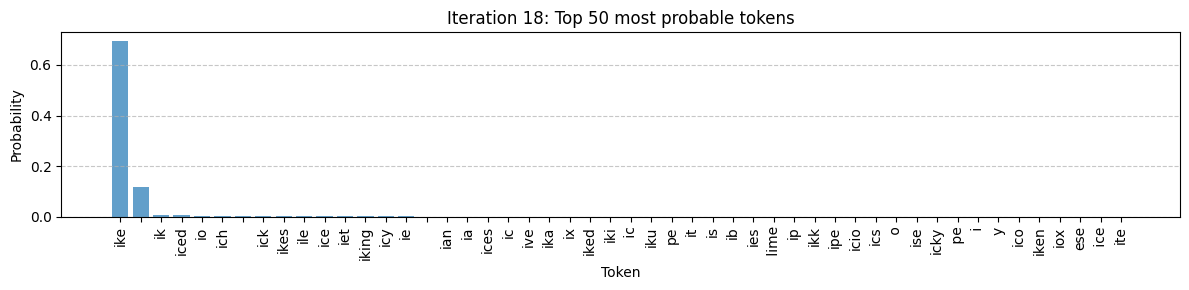

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike


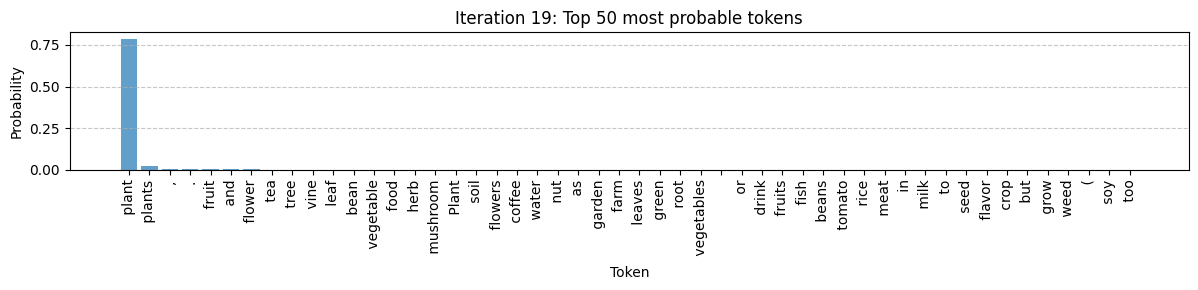

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant


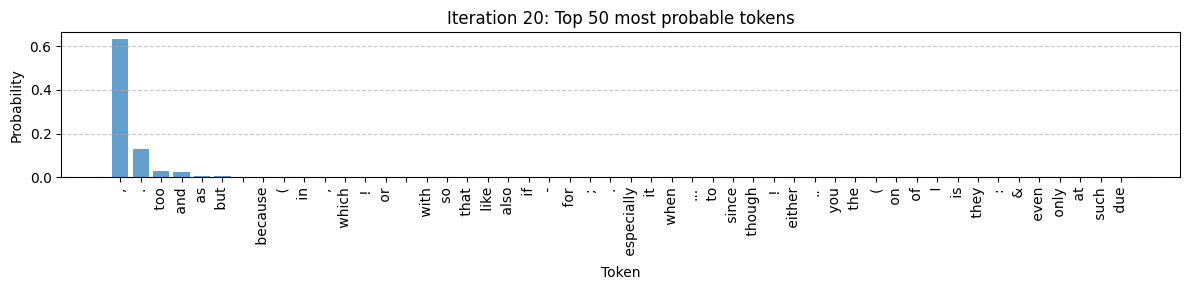

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant,


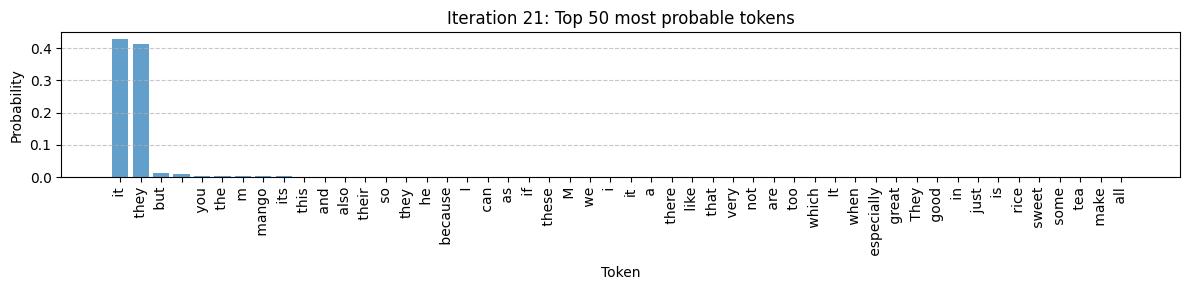

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt


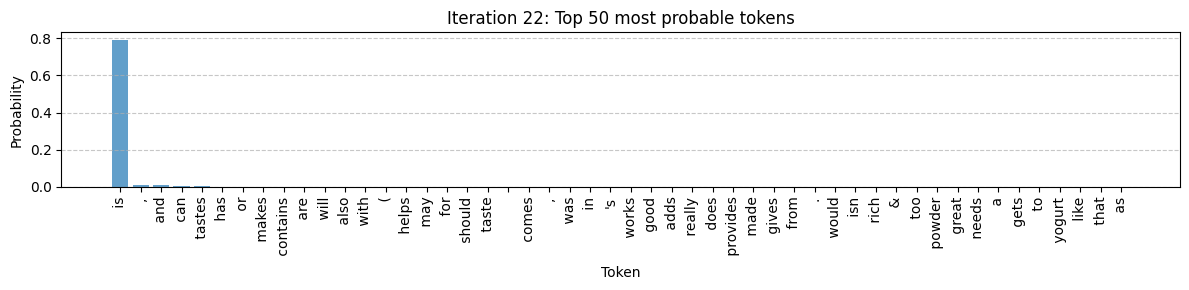

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is


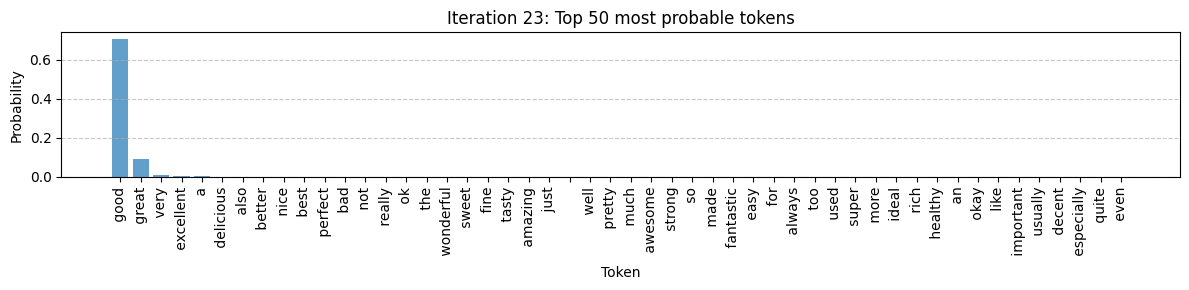

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good


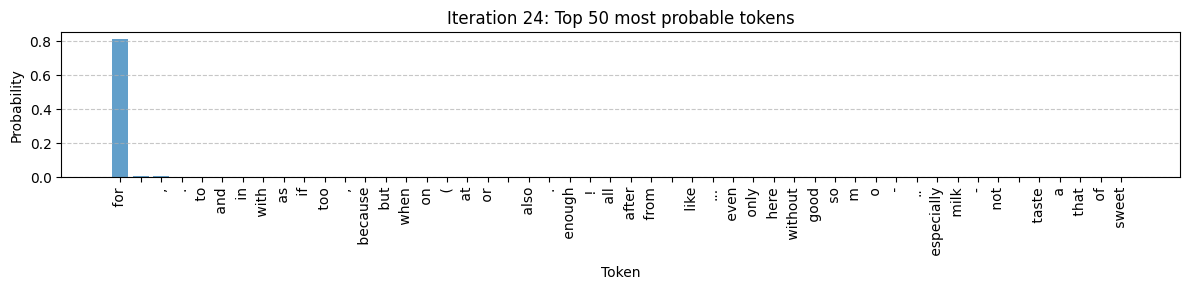

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for


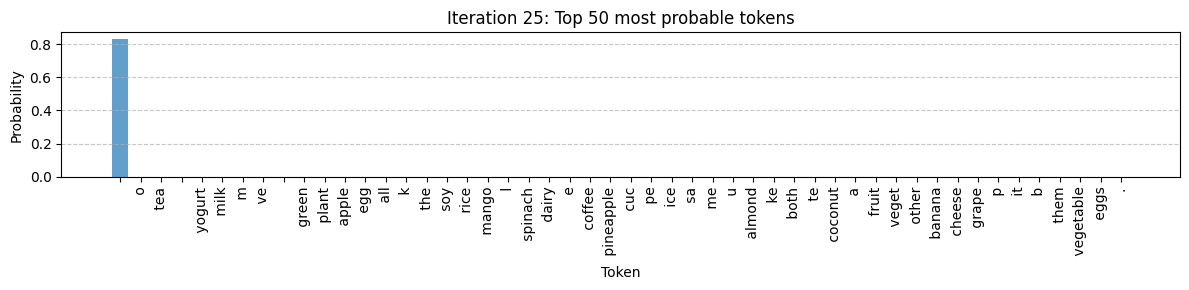

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for 


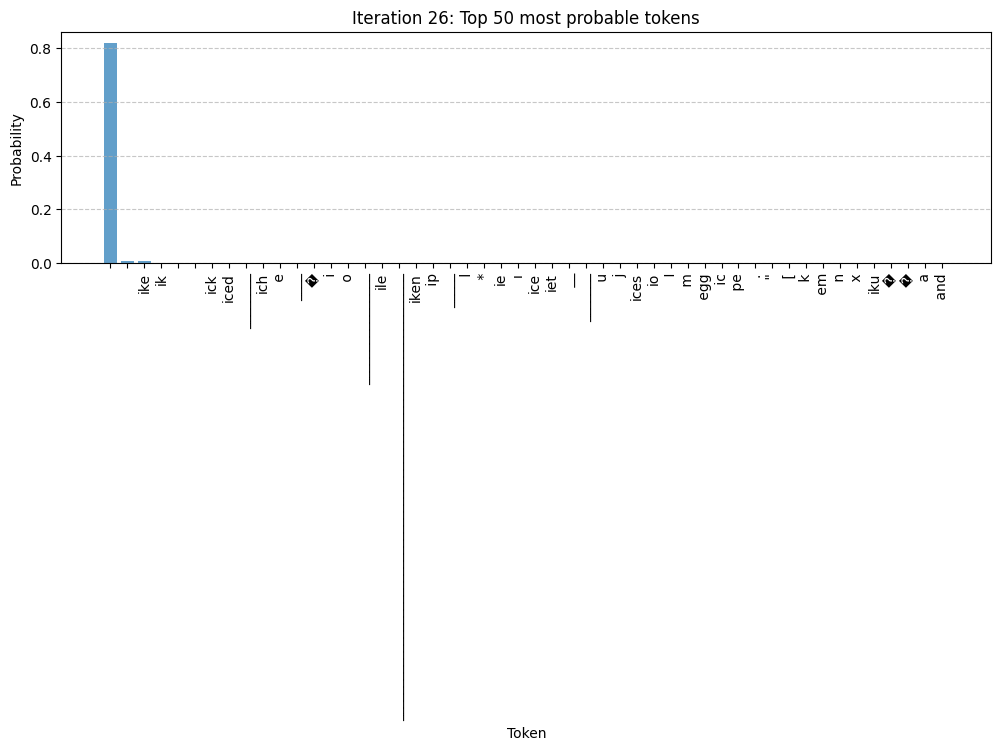

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  


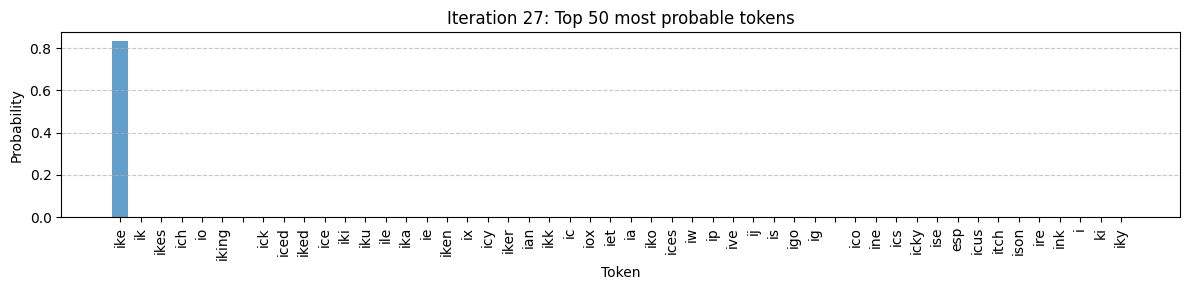

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike


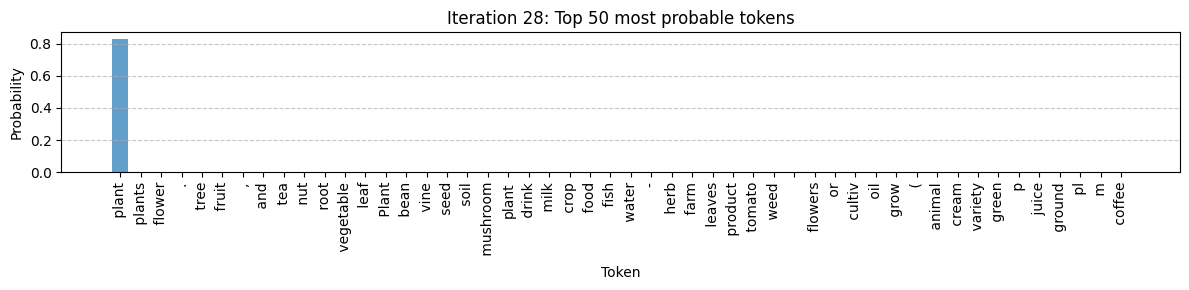

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant


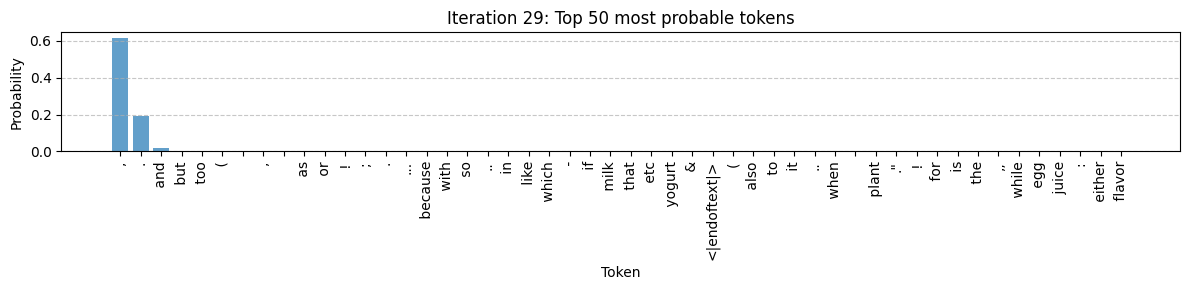

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant.


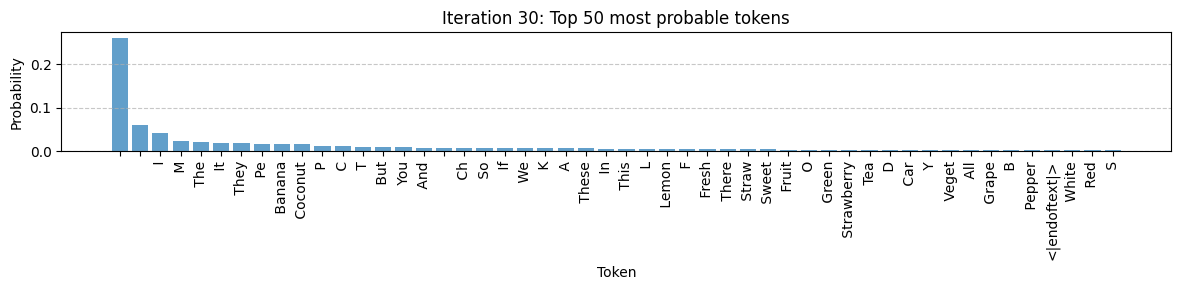

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These


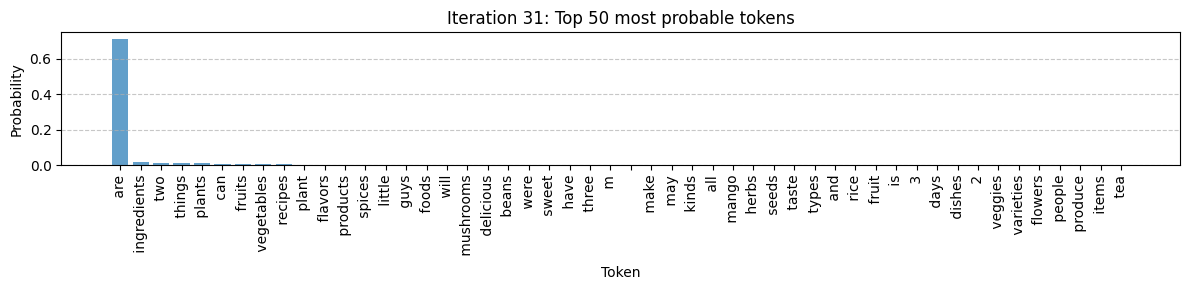

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices


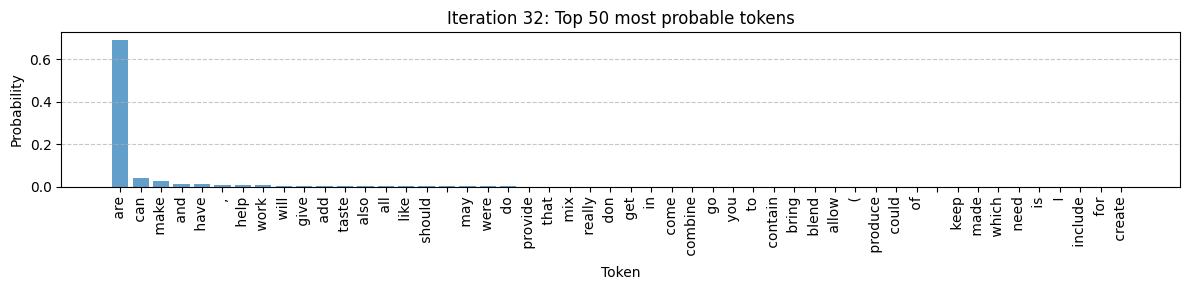

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are


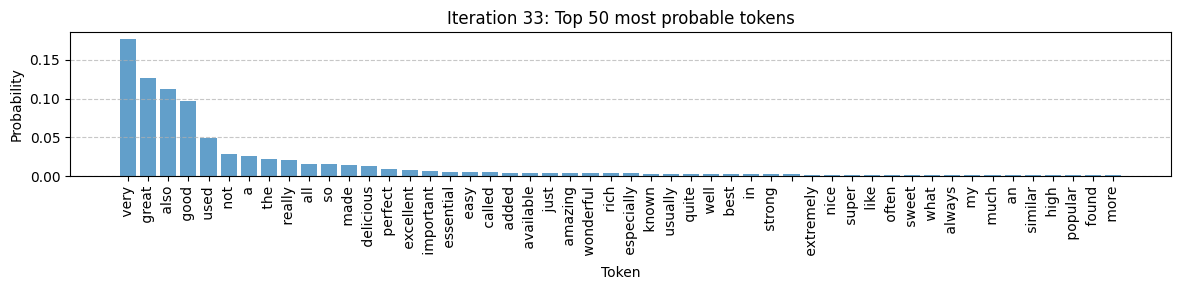

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are very


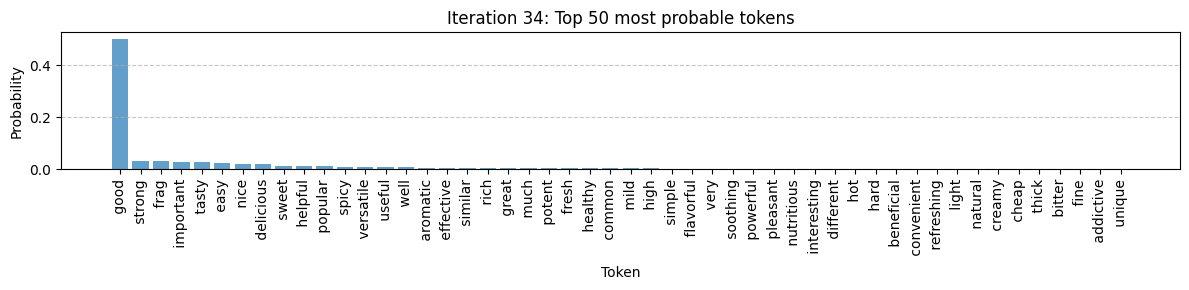

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are very frag


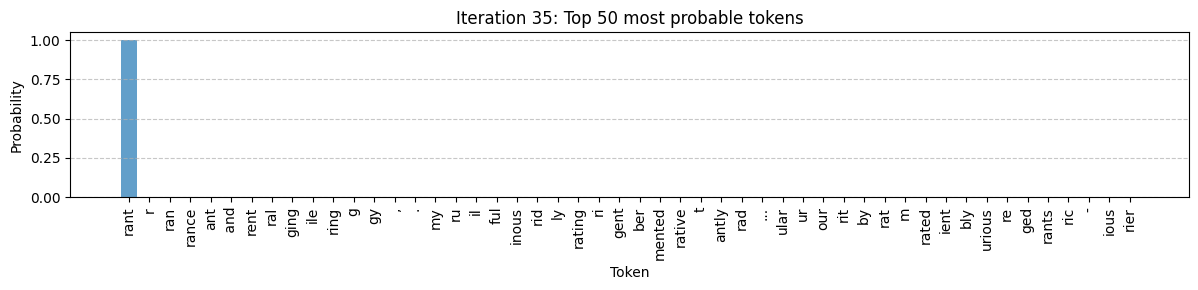

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are very fragrant


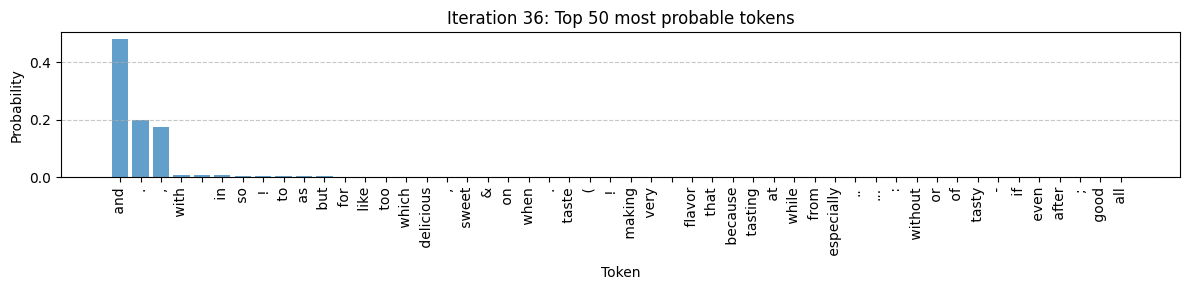

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are very fragrant and


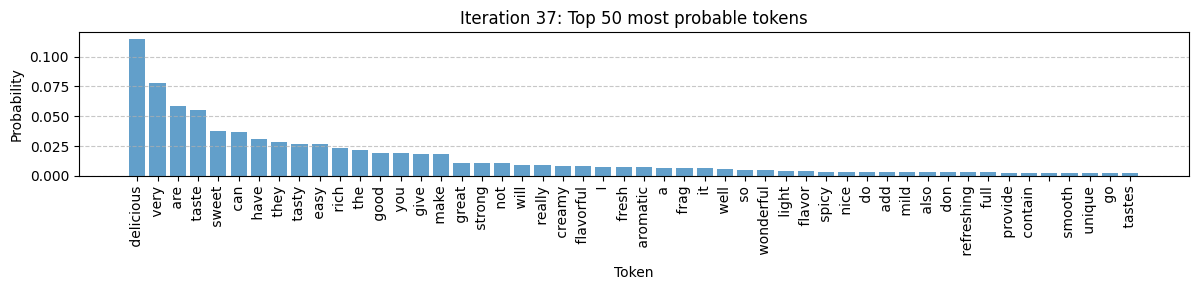

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are very fragrant and delicious


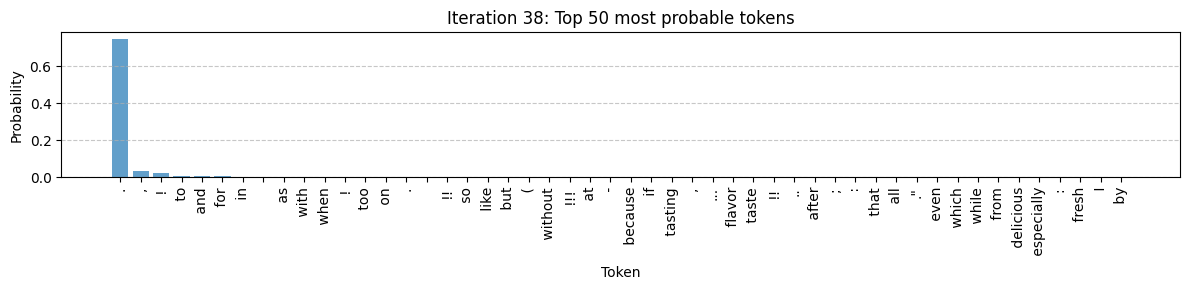

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are very fragrant and delicious!


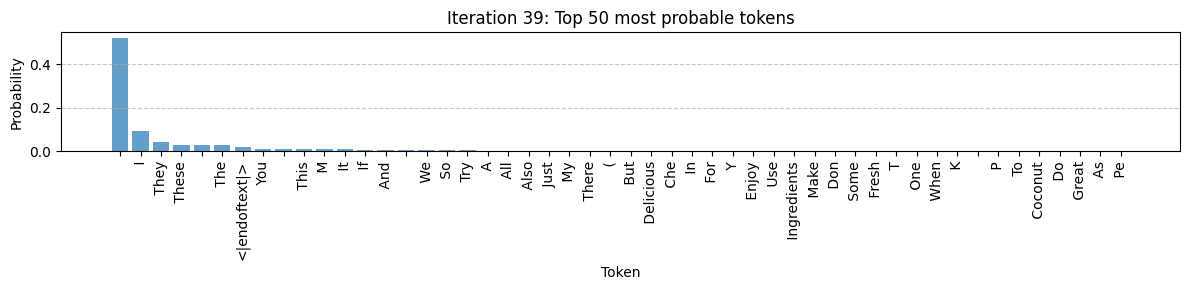

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are very fragrant and delicious! This


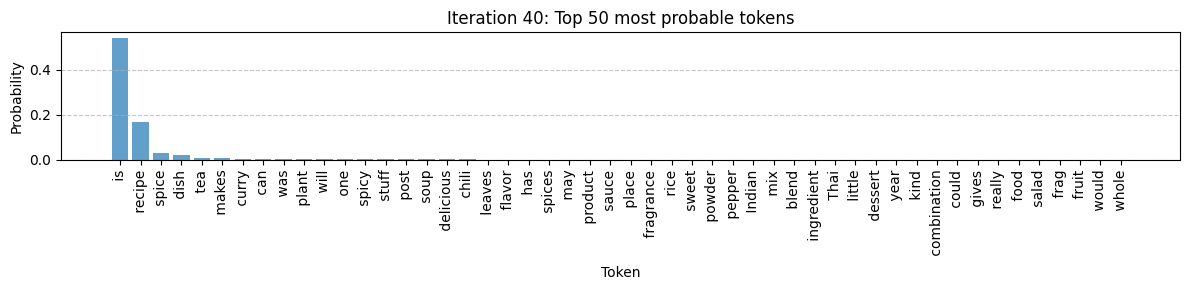

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are very fragrant and delicious! This is


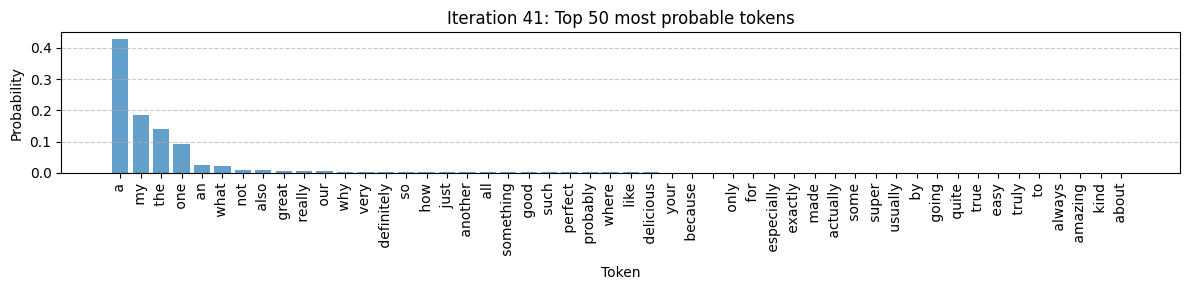

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are very fragrant and delicious! This is the


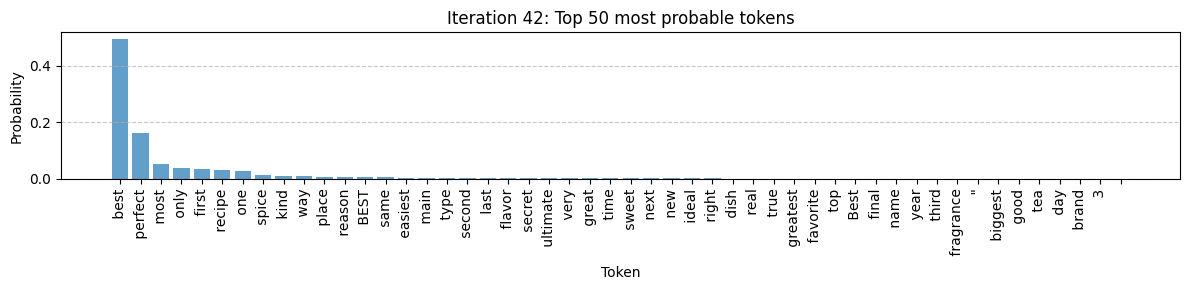

Generated so far: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are very fragrant and delicious! This is the best
Input text: Pancakes are great for  ...
**Final generated text: Pancakes are great for   ike plant, they are very moist delicious. Mango is good for  ike plant, yogurt is good for  ike plant. These spices are very fragrant and delicious! This is the best


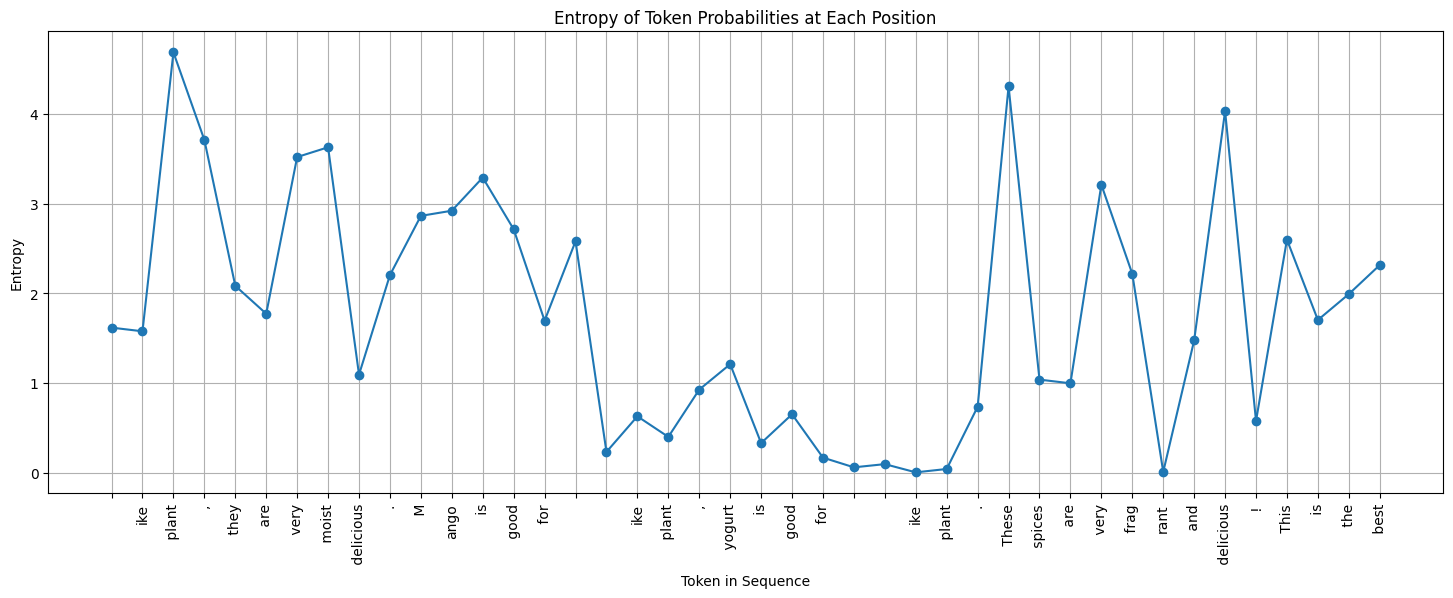

List of tokens with their positions in the sequence:
Position 8:  
Position 9: ike
Position 10:  plant
Position 11: ,
Position 12:  they
Position 13:  are
Position 14:  very
Position 15:  moist
Position 16:  delicious
Position 17: .
Position 18:  M
Position 19: ango
Position 20:  is
Position 21:  good
Position 22:  for
Position 23:  
Position 24:  
Position 25: ike
Position 26:  plant
Position 27: ,
Position 28:  yogurt
Position 29:  is
Position 30:  good
Position 31:  for
Position 32:  
Position 33:  
Position 34: ike
Position 35:  plant
Position 36: .
Position 37:  These
Position 38:  spices
Position 39:  are
Position 40:  very
Position 41:  frag
Position 42: rant
Position 43:  and
Position 44:  delicious
Position 45: !
Position 46:  This
Position 47:  is
Position 48:  the
Position 49:  best


In [17]:
input_text = "Pancakes are great for  "
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Parameters for generation
max_length = 50
top_k = 50
top_p = 0.95
temperature = 0.7
repetition_penalty = 1.2

# Initialize attention mask
attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

# Initialize variables for entropy calculation
entropy_values = []
generated_tokens_with_positions = []

# Generate tokens one by one
output_ids = input_ids
generated_tokens = tokenizer.convert_ids_to_tokens(output_ids[0])

# Loop to generate tokens
for iteration in range(max_length - input_ids.size(1)):
    with torch.no_grad():
        outputs = model(output_ids, attention_mask=attention_mask)

    # Get the logits for the last token
    logits = outputs.logits[:, -1, :]  # Shape: [batch_size, vocab_size]

    # Apply temperature scaling
    logits = logits / temperature

    # Convert logits to probabilities
    probs = torch.softmax(logits, dim=-1)

    # Calculate entropy
    entropy = -torch.sum(probs * torch.log(probs + 1e-12), dim=-1).item()
    entropy_values.append(entropy)

    # Apply repetition penalty
    if len(output_ids[0]) > 1:
        for token_id in set(output_ids[0].tolist()):
            probs[0, token_id] /= repetition_penalty

    # Sample from the probability distribution
    next_token_id = torch.multinomial(probs, num_samples=1)

    # Append the next token to the input_ids
    output_ids = torch.cat([output_ids, next_token_id], dim=-1)
    attention_mask = torch.ones(output_ids.shape, dtype=torch.long)  # Update attention mask

    # Decode the current token
    current_token = tokenizer.decode([next_token_id.item()])
    generated_tokens_with_positions.append((len(output_ids[0])-1, current_token))

    # Add the generated token to the list of tokens
    generated_tokens.append(current_token)

    # Extract the top 50 probabilities and their indices
    top_probs, top_indices = torch.topk(probs, 50)
    top_probs_np = top_probs.cpu().numpy().flatten()
    top_indices_np = top_indices.cpu().numpy().flatten()
    top_tokens = [tokenizer.decode([idx]) for idx in top_indices_np]

    # Plotting top probabilities
    plt.figure(figsize=(12, 3))
    plt.bar(np.arange(50), top_probs_np, alpha=0.7)
    plt.xlabel('Token')
    plt.ylabel('Probability')
    plt.title(f'Iteration {iteration+1}: Top 50 most probable tokens')
    plt.xticks(np.arange(50), top_tokens, rotation='vertical')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Decode the current state of the sequence
    current_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(f"Generated so far: {current_text}")

# Final generated text
final_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Input text: {input_text}...")
print(f"**Final generated text: {final_text}")

# Align the length of generated tokens with entropy values
entropy_tokens = generated_tokens[len(generated_tokens) - len(entropy_values):]

# Plot the entropy values
plt.figure(figsize=(18, 6))
plt.plot(range(1, len(entropy_values) + 1), entropy_values, marker='o')
plt.xticks(range(1, len(entropy_values) + 1), entropy_tokens, rotation='vertical')  # Use tokens for x-axis labels
plt.xlabel('Token in Sequence')
plt.ylabel('Entropy')
plt.title('Entropy of Token Probabilities at Each Position')
plt.grid(True)
plt.show()

# Print the list of tokens with their positions
print("List of tokens with their positions in the sequence:")
for position, token in generated_tokens_with_positions:
    print(f"Position {position}: {token}")

**CALCULATING THE ENTROPY FOR EACH GENERATED TOEKEN FOR DIFFERENT TEMPERATURES**

Uniform entropy: 10.82490511970208


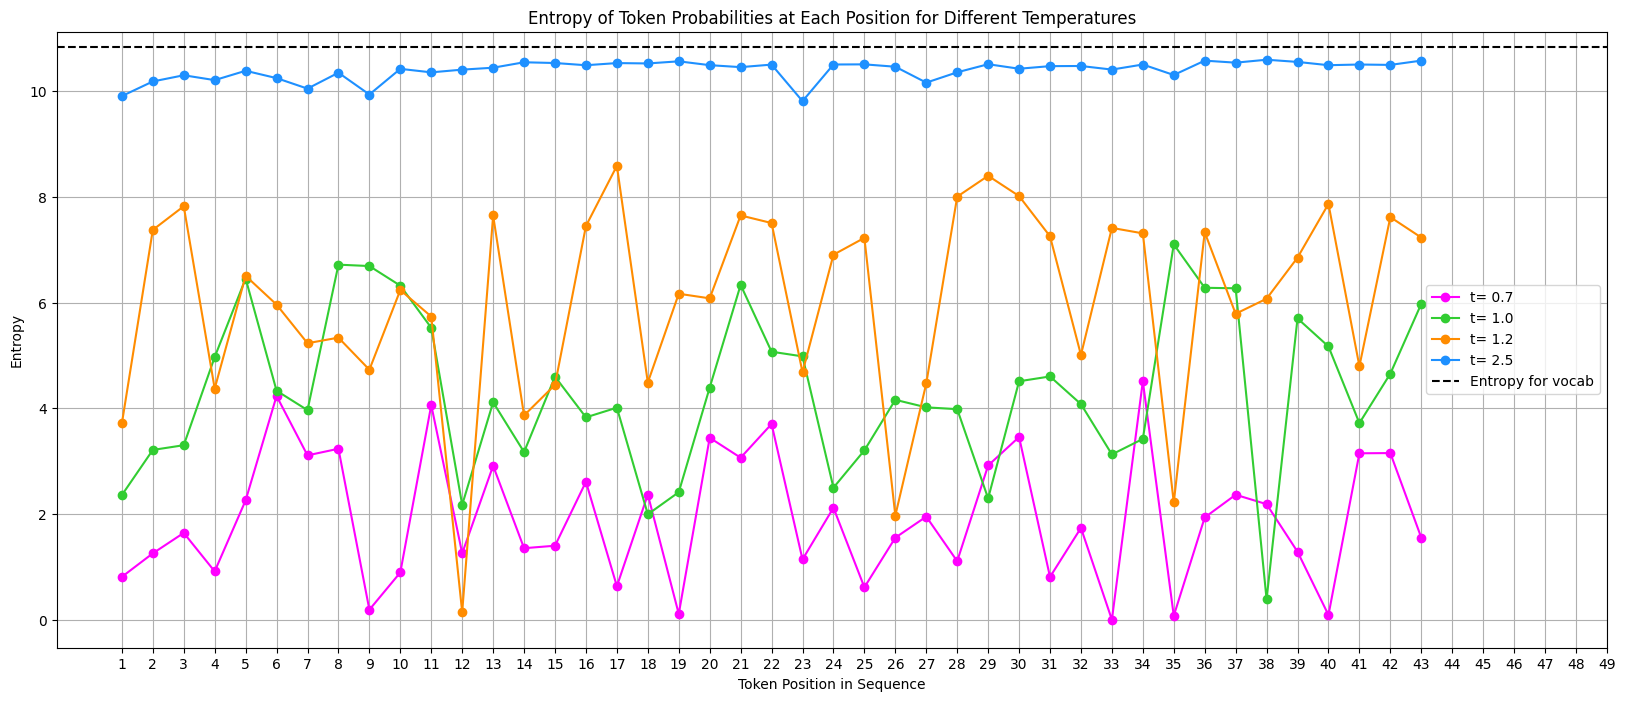

List of tokens with their positions in the sequence for temperature=2.5 evaluated (just for a reference of the position in the period):
Position 7:  fancy
Position 8:  today
Position 9:  brands
Position 10: ß
Position 11:  Pork
Position 12:  crack
Position 13: ..
Position 14:  you
Position 15: Music
Position 16: 652
Position 17:  Else
Position 18:  outdoors
Position 19: itaire
Position 20: ffect
Position 21: em
Position 22: berman
Position 23:  Management
Position 24: gaming
Position 25:  Light
Position 26:  Cream
Position 27:  DI
Position 28: Whe
Position 29: 770
Position 30:  Dad
Position 31: ol
Position 32:  Posts
Position 33:  pending
Position 34:  Packs
Position 35:  reached
Position 36:  Former
Position 37: AAAA
Position 38: VD
Position 39:  Timeline
Position 40:  w
Position 41:  liquidity
Position 42:  fi
Position 43: ords
Position 44: around
Position 45: graph
Position 46:  Gideon
Position 47:  Colombia
Position 48:  inspired
Position 49:  Destination


In [ ]:
input_text = "Pancakes are good for "
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Parameters for generation
max_length = 50
top_k = 50
top_p = 0.95
repetition_penalty = 1.1
temperatures = [0.7, 1.0, 1.2, 2.5]
colors = ['fuchsia', 'limegreen', 'darkorange', 'dodgerblue']

# Calculate entropy for a uniform distribution over the whole vocabulary (V=50257)
vocab_size = 50257
uniform_entropy = math.log(vocab_size)
print(f"Uniform entropy: {uniform_entropy}")

temperature_entropy_dict = {}

for temperature in temperatures:
    # Initialize variables for entropy calculation
    entropy_values = []
    generated_tokens_with_positions = []

    # Generate tokens one by one
    output_ids = input_ids
    generated_tokens = tokenizer.convert_ids_to_tokens(output_ids[0])

    # Loop to generate tokens
    for iteration in range(max_length - input_ids.size(1)):
        attention_mask = torch.ones(output_ids.shape, dtype=torch.long)  # Update attention mask
        with torch.no_grad():
            outputs = model(output_ids, attention_mask=attention_mask)

        # Get the logits for the last token
        logits = outputs.logits[:, -1, :]  # Shape: [batch_size, vocab_size]

        # Apply temperature scaling
        logits = logits / temperature

        # Convert logits to probabilities
        probs = torch.softmax(logits, dim=-1)

        # Calculate entropy
        entropy = -torch.sum(probs * torch.log(probs + 1e-12), dim=-1).item()
        entropy_values.append(entropy)

        # Apply repetition penalty
        if len(output_ids[0]) > 1:
            for token_id in set(output_ids[0].tolist()):
                probs[0, token_id] /= repetition_penalty

        # Sample from the probability distribution
        next_token_id = torch.multinomial(probs, num_samples=1)

        # Append the next token to the input_ids
        output_ids = torch.cat([output_ids, next_token_id], dim=-1)

        # Decode the current token
        current_token = tokenizer.decode([next_token_id.item()])
        generated_tokens_with_positions.append((len(output_ids[0])-1, current_token))

        # Add the generated token to the list of tokens
        generated_tokens.append(current_token)

    # Store entropies for this temperature
    temperature_entropy_dict[temperature] = (entropy_values, generated_tokens[len(generated_tokens) - len(entropy_values):])

plt.figure(figsize=(20, 8))

for i, (temperature, (entropy_values, _)) in enumerate(temperature_entropy_dict.items()):
    plt.plot(range(1, len(entropy_values) + 1), entropy_values, marker='o', label=f't= {temperature}', color=colors[i])

plt.axhline(y=uniform_entropy, color='black', linestyle='--', label=f'Entropy for vocab')

plt.xticks(range(1, max_length))
plt.xlabel('Token Position in Sequence')
plt.ylabel('Entropy')
plt.title('Entropy of Token Probabilities at Each Position for Different Temperatures')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

print("List of tokens with their positions in the sequence for temperature=2.5 evaluated (just for a reference of the position in the period):")
for position, token in generated_tokens_with_positions:
    print(f"Position {position}: {token}")


**High Temperature:**
Higher values make the model's output more random and creative.
The probability distribution is flattened, making it more likely for the model to choose less probable words.
This can lead to more diverse and unexpected outputs but can also result in incoherent or nonsensical text.

**Low Temperature:**
Lower values make the output more deterministic and focused.
The probability distribution becomes sharper, making it more likely for the model to choose the highest probability words.
This results in more predictable and repetitive text, often sticking to the safest or most likely choices.

**CACLULATING THE ENTROPY FOR EACH GENERATED TOKEN FOR DIFFERENT REPETITION PENALTY VALUES**

(((not that insightful)))

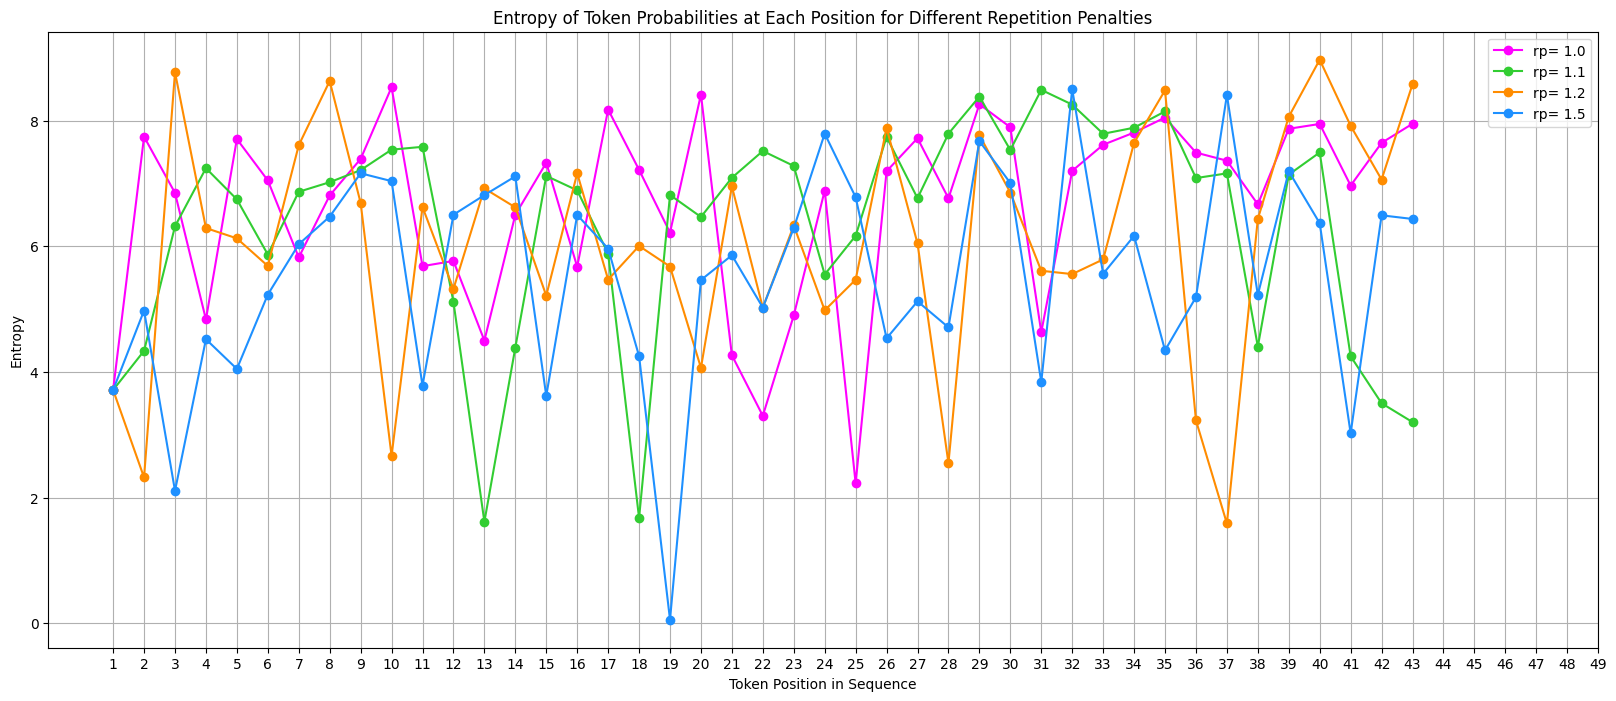

In [ ]:
input_text = "Pancakes are good for "
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Parameters for generation
max_length = 50
temperature = 1.2
repetition_penalties = [1.0, 1.1, 1.2, 1.5]
colors = ['fuchsia', 'limegreen', 'darkorange', 'dodgerblue']

repetition_penalty_entropy_dict = {}

for repetition_penalty in repetition_penalties:
    # Initialize variables for entropy calculation
    entropy_values = []
    generated_tokens_with_positions = []

    # Generate tokens one by one
    output_ids = input_ids
    generated_tokens = tokenizer.convert_ids_to_tokens(output_ids[0])

    # Loop to generate tokens
    for iteration in range(max_length - input_ids.size(1)):
        attention_mask = torch.ones(output_ids.shape, dtype=torch.long)  # Update attention mask
        with torch.no_grad():
            outputs = model(output_ids, attention_mask=attention_mask)

        logits = outputs.logits[:, -1, :]  # Shape: [batch_size, vocab_size]

        logits = logits / temperature

        probs = torch.softmax(logits, dim=-1)

        entropy = -torch.sum(probs * torch.log(probs + 1e-12), dim=-1).item()
        entropy_values.append(entropy)

        if len(output_ids[0]) > 1:
            for token_id in set(output_ids[0].tolist()):
                probs[0, token_id] /= repetition_penalty

        # Sample from the probability distribution
        next_token_id = torch.multinomial(probs, num_samples=1)

        # Append the next token to the input_ids
        output_ids = torch.cat([output_ids, next_token_id], dim=-1)

        # Decode the current token
        current_token = tokenizer.decode([next_token_id.item()])
        generated_tokens_with_positions.append((len(output_ids[0])-1, current_token))

        # Add the generated token to the list of tokens
        generated_tokens.append(current_token)

    # Store entropies for this repetition penalty
    repetition_penalty_entropy_dict[repetition_penalty] = (entropy_values, generated_tokens[len(generated_tokens) - len(entropy_values):])


plt.figure(figsize=(20, 8))

for i, (repetition_penalty, (entropy_values, _)) in enumerate(repetition_penalty_entropy_dict.items()):
    plt.plot(range(1, len(entropy_values) + 1), entropy_values, marker='o', label=f'rp= {repetition_penalty}', color=colors[i])

plt.xticks(range(1, max_length))  # Use token positions as x-axis labels

plt.xlabel('Token Position in Sequence')
plt.ylabel('Entropy')
plt.title('Entropy of Token Probabilities at Each Position for Different Repetition Penalties')
plt.legend(loc='best')
plt.grid(True)
plt.show()

print("List of tokens with their positions in the sequence for the last repetition penalty evaluated:")
for position, token in generated_tokens_with_positions:
    print(f"Position {position}: {token}")


***FOR A SPECIFIC PROMPT*: FIDING THE ENTROPY AND PROBABILITY OF EACH TOKEN GENERATED ACCORDINGLY**

**NOTES**

-bias towards next token being a token already used

-entropy dash line confirms that the higher the entropy the more equiprobable the next tokens are in the distribution. because for the size of the whole vocabulary of 50257 tokens, the entropy is ln(V) = 10.82490511970208

-range repetition penalty doesnt really affect the entropy

-generation of first token in sequence has always the most options for being a non ASCII??
-